In [1]:
import numpy as np, random, os
import torch
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Seed={SEED} | Device={DEVICE}")
torch.cuda.empty_cache() if DEVICE=="cuda" else None


✅ Seed=42 | Device=cuda


In [2]:
import os
from pathlib import Path
import sys

# --- Détection du projet (exécution depuis notebooks/) ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "06b_cgan_ia"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "06b_cgan_ia"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "06b_cgan_ia"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "06b_cgan_ia"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

# Création des dossiers
for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Ajout du datagenerator au path
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

# Ajout du chemin des métriques au path
if str(PROJECT_ROOT / "metrics") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "metrics"))

# Import des mappings de classes
from utils.class_mappings import class_labels, class_colors, make_idx_mappings

# Import de la fonction Duet-FID corrigée
from gan_metrics.duet_fid import duet_frechet_cond

# Alias pour compatibilité
CKPT_DIR = CHECKPOINTS_DIR
METRICS_DIR = ARTIFACTS_DIR / "06b_cgan_ia" / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)

IMAGE_SIZE = 256
BATCH_SIZE = 8   # 4 teste 8 pour plusieurs classes
NUM_WORKERS = 0
PIN_MEMORY = (DEVICE=="cuda")
DROP_LAST = True
SHUFFLE = True

# Classes ciblées (utilise le filtrage du HistoDataset)
SELECTED_CLASSES = None  # mets None pour toutes , ["TUM""STR","NORM"]

# Affichage des dossiers configurés
print("✅ Dossiers configurés:")
print(f"   PROJECT_ROOT    : {PROJECT_ROOT}")
print(f"   DATA_ROOT       : {DATA_ROOT}")
print(f"   CONFIG_DIR      : {CONFIG_DIR}")
print(f"   MODELS_DIR      : {MODELS_DIR}")
print(f"   ARTIFACTS_DIR   : {ARTIFACTS_DIR}")
print(f"   SAMPLES_DIR     : {SAMPLES_DIR}")
print(f"   OUTPUTS_DIR     : {OUTPUTS_DIR}")
print(f"   CHECKPOINTS_DIR : {CHECKPOINTS_DIR}")
print(f"   RUNS_DIR        : {RUNS_DIR}")
print(f"   METRICS_DIR     : {METRICS_DIR}")


✅ Dossiers configurés:
   PROJECT_ROOT    : /workspace
   DATA_ROOT       : /workspace/data
   CONFIG_DIR      : /workspace/configs
   MODELS_DIR      : /workspace/models
   ARTIFACTS_DIR   : /workspace/artifacts
   SAMPLES_DIR     : /workspace/samples/06b_cgan_ia
   OUTPUTS_DIR     : /workspace/outputs/06b_cgan_ia
   CHECKPOINTS_DIR : /workspace/checkpoints/06b_cgan_ia
   RUNS_DIR        : /workspace/runs/06b_cgan_ia
   METRICS_DIR     : /workspace/artifacts/06b_cgan_ia/metrics


In [3]:
# Import du datagenerator (DATAGENERATOR_PATH déjà ajouté au path dans la cellule 1)
from histo_dataset import HistoDataset
from torch.utils.data import DataLoader, Subset

PIXEL_RANGE = "-1_1"
SAMPLES_PER_CLASS = 2000
VAHADANE_ENABLE = True

ds_gan = HistoDataset(
    root_data=str(DATA_ROOT),
    split="train",
    output_size=IMAGE_SIZE,
    pixel_range=PIXEL_RANGE,
    balance_per_class=True,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS,
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_device=DEVICE,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),  # Référence Vahadane
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    return_labels=True,
    classes=SELECTED_CLASSES,
)
print("✅ Dataset cGAN initialisé")
print("Classes retenues:", ds_gan.class_counts())
num_classes = len(ds_gan.class_counts())
print("num_classes =", num_classes)

loader_gan = DataLoader(
    dataset=ds_gan,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=DROP_LAST,
)
xb, yb, _ = next(iter(loader_gan))
print(f"Batch: x={tuple(xb.shape)}, y={tuple(yb.shape)} → min={xb.min():.3f}, max={xb.max():.3f}")

# held-out pour métriques (régénère si incompatible)
import numpy as np
HELDOUT_IDX_PATH = METRICS_DIR / "duet_eval_idx.npy"
N_EVAL_POOL = 2000
rng = np.random.default_rng(42)
all_idx = np.arange(len(ds_gan))
pick = min(N_EVAL_POOL, len(all_idx))
regenerate = True
if HELDOUT_IDX_PATH.exists():
    try:
        tmp = np.load(HELDOUT_IDX_PATH)
        # invalide si vide, si max hors bornes, ou si taille < 1
        if tmp.size > 0 and int(tmp.max()) < len(ds_gan):
            eval_idx = tmp
            regenerate = False
        else:
            regenerate = True
    except Exception:
        regenerate = True
if regenerate:
    eval_idx = rng.choice(all_idx, size=pick, replace=False)
    np.save(HELDOUT_IDX_PATH, eval_idx)

class StripXY(torch.utils.data.Dataset):
    def __init__(self, base): self.base=base
    def __len__(self): return len(self.base)
    def __getitem__(self, i): x, y, p = self.base[i]; return x

ds_eval = Subset(ds_gan, eval_idx.tolist())
loader_real_eval = DataLoader(StripXY(ds_eval), batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
print("✅ loader_real_eval prêt:", len(ds_eval))


🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (2000 images / classe).
✅ Dataset cGAN initialisé
Classes retenues: {'ADI': 10407, 'BACK': 10566, 'DEB': 11512, 'LYM': 11557, 'MUC': 8896, 'MUS': 13536, 'NORM': 8763, 'STR': 10446, 'TUM': 14317}
num_classes = 9
Batch: x=(8, 3, 256, 256), y=(8,) → min=-0.984, max=1.000
✅ loader_real_eval prêt: 1000


In [4]:
# PathoDuet extractor (gelé) basé sur timm (DeiT-B/16 224), chargement ckpt HE
import re, torch
import torch.nn as nn
import torch.nn.functional as F
try:
    import timm
except Exception as e:
    raise RuntimeError("Installe 'timm' (pip install timm)")

CKPT_PATH = MODELS_DIR / "checkpoint_HE.pth"
assert CKPT_PATH.exists(), f"Checkpoint introuvable: {CKPT_PATH}"

def load_state_dict_safely(path):
    sd_raw = None
    try:
        obj = torch.load(path, map_location="cpu", weights_only=True)
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict","model","module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
    except TypeError:
        obj = torch.load(path, map_location="cpu")
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict","model","module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
    if sd_raw is None:
        raise RuntimeError("state_dict non trouvé dans le ckpt")
    clean_sd = {re.sub(r"^(module\.|model\.)","",k): v for k, v in sd_raw.items()}
    # retirer distillation + réajuster pos_embed 198→197
    clean_sd.pop("dist_token", None)
    for k in list(clean_sd.keys()):
        if k.startswith("head_dist."): clean_sd.pop(k)
    if "pos_embed" in clean_sd and clean_sd["pos_embed"].shape[1] == 198:
        pos = clean_sd["pos_embed"]
        clean_sd["pos_embed"] = torch.cat([pos[:, :1, :], pos[:, 2:, :]], dim=1)
    for k in list(clean_sd.keys()):
        if k.startswith("head."): clean_sd.pop(k)
    return clean_sd

state_dict = load_state_dict_safely(CKPT_PATH)
backbone = timm.create_model("deit_base_patch16_224", pretrained=False, num_classes=0, img_size=224, global_pool="avg")
missing, unexpected = backbone.load_state_dict(state_dict, strict=False)
for p in backbone.parameters(): p.requires_grad_(False)
backbone.eval()

class PathoDuetExtractor(nn.Module):
    def __init__(self, bb, in_size=224):
        super().__init__(); self.bb=bb; self.in_size=in_size
    @torch.no_grad()
    def forward(self, x_m11):
        x01 = (x_m11.clamp(-1,1) + 1)*0.5
        if x01.shape[-2:] != (self.in_size, self.in_size):
            x01 = F.interpolate(x01, size=(self.in_size,self.in_size), mode="bilinear", align_corners=False)
        return self.bb(x01)

pathoduet = PathoDuetExtractor(backbone).to(DEVICE)
with torch.no_grad():
    f = pathoduet(xb.to(DEVICE)[:2])
print("PathoDuet features:", tuple(f.shape))


PathoDuet features: (2, 768)


In [5]:
# cGAN: Générateur (StyleGAN-lite) conditionnel (embedding classe → mapping)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as nn_utils

class MappingNetwork(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, n_layers=8):
        super().__init__()
        layers = []
        dim = z_dim
        for _ in range(n_layers):
            layers += [nn.Linear(dim, w_dim), nn.LeakyReLU(0.2, inplace=True)]
            dim = w_dim
        self.mapping = nn.Sequential(*layers)
    def forward(self, z):
        z = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        return self.mapping(z)

class ModulatedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, style_dim, demod=True, up=False):
        super().__init__(); self.up=up; self.demod=demod; self.eps=1e-8; self.pad=kernel//2
        self.weight = nn.Parameter(torch.randn(1, out_ch, in_ch, kernel, kernel))
        self.style = nn.Linear(style_dim, in_ch)
    def forward(self, x, s):
        if self.up:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        b, c, h, w = x.shape
        w1 = self.style(s).view(b, 1, c, 1, 1)
        w2 = self.weight * (w1 + 1)
        if self.demod:
            d = torch.rsqrt((w2 ** 2).sum([2,3,4]) + self.eps)
            w2 = w2 * d.view(b, -1, 1, 1, 1)
        x = x.view(1, -1, h, w)
        w2 = w2.view(b * w2.size(1), w2.size(2), w2.size(3), w2.size(4))
        out = F.conv2d(x, w2, padding=self.pad, groups=b)
        return out.view(b, -1, out.shape[-2], out.shape[-1])

class Generator(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, img_res=256, fmap_base=256, num_classes=9):
        super().__init__()
        self.z_dim = z_dim
        self.w_dim = w_dim
        self.num_blocks = 0  # Compteur de blocs pour style mixing
        self.embed = nn.Embedding(num_classes, z_dim)
        nn.init.normal_(self.embed.weight, std=0.02)
        self.mapping = MappingNetwork(z_dim, w_dim)
        self.const = nn.Parameter(torch.randn(1, fmap_base, 4, 4))
        self.blocks = nn.ModuleList()
        in_ch = fmap_base; res = 4
        while res < img_res:
            out_ch = max(fmap_base // max(res // 8, 1), 64)
            # ✅ AMÉLIORATION AUDACIEUSE : Noise injection pour chaque bloc
            # Ajoute du bruit appris pour plus de détails et de diversité
            noise_weight = nn.Parameter(torch.zeros(1, out_ch, 1, 1))
            self.register_parameter(f'noise_{self.num_blocks}', noise_weight)
            self.blocks.append(nn.ModuleList([
                ModulatedConv2d(in_ch, out_ch, 3, w_dim, up=True), nn.LeakyReLU(0.2, inplace=True),
                ModulatedConv2d(out_ch, out_ch, 3, w_dim, up=False), nn.LeakyReLU(0.2, inplace=True),
            ]))
            in_ch = out_ch; res *= 2
            self.num_blocks += 1
        self.to_rgb = nn.Conv2d(in_ch, 3, 1)
        # ✅ AMÉLIORATION : Initialisation Xavier pour to_rgb (meilleure initialisation)
        nn.init.xavier_uniform_(self.to_rgb.weight, gain=0.8)
        if self.to_rgb.bias is not None:
            nn.init.constant_(self.to_rgb.bias, 0.0)
    
    def forward(self, z, y, w_mix=None, mix_prob=0.9):
        """
        Args:
            z: latent code (B, z_dim)
            y: class labels (B,)
            w_mix: latent code alternatif pour style mixing (B, z_dim) - optionnel
            mix_prob: probabilité de style mixing par bloc
        """
        zc = z + self.embed(y)
        w = self.mapping(zc)
        
        # ✅ AMÉLIORATION AUDACIEUSE : Style Mixing
        # Mélange les styles de différentes latentes pour plus de diversité
        if w_mix is not None and self.training:
            y_mix = torch.randint(0, self.embed.num_embeddings, (z.size(0),), device=z.device)
            zc_mix = w_mix + self.embed(y)  # 🔁 y, pas y_mix
            w_mix_mapped = self.mapping(zc_mix)
        else:
            w_mix_mapped = None
        
        x = self.const.repeat(z.size(0), 1, 1, 1)
        for i, (m1, a1, m2, a2) in enumerate(self.blocks):
            # Style mixing : utiliser w_mix pour certains blocs
            if w_mix_mapped is not None and self.training and torch.rand(1).item() < mix_prob:
                w_use = w_mix_mapped
            else:
                w_use = w
            
            x = m1(x, w_use)
            # ✅ AMÉLIORATION AUDACIEUSE : Noise injection
            if self.training:
                noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
                noise_weight = getattr(self, f'noise_{i}')
                # Adapter la taille du noise_weight si nécessaire
                if noise_weight.shape[1] != x.shape[1]:
                    # Utiliser le premier canal si dimensions ne correspondent pas
                    noise_weight_adj = noise_weight[:, :1, :, :]
                else:
                    noise_weight_adj = noise_weight
                x = x + noise * noise_weight_adj
            x = a1(x)
            x = m2(x, w_use)
            # Noise après la deuxième conv aussi (même poids)
            if self.training:
                noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
                noise_weight = getattr(self, f'noise_{i}')
                if noise_weight.shape[1] != x.shape[1]:
                    noise_weight_adj = noise_weight[:, :1, :, :]
                else:
                    noise_weight_adj = noise_weight
                x = x + noise * noise_weight_adj
            x = a2(x)
        
        # ✅ Protection contre la saturation : clamp après tanh pour éviter les valeurs extrêmes
        output = torch.tanh(self.to_rgb(x))
        # ✅ CORRECTION DIVERGENCE : Clamp plus strict (0.9 au lieu de 0.95) pour éviter la saturation
        # Limite à [-0.9, 0.9] au lieu de [-1, 1] pour éviter complètement la saturation
        output = output.clamp(-0.9, 0.9)
        return output

class Discriminator(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        def C(i,o,k=3,s=2,p=1): return nn_utils.spectral_norm(nn.Conv2d(i,o,k,s,p))
        self.body = nn.Sequential(
            C(3, ch,3,2,1), nn.LeakyReLU(0.2, inplace=True),
            C(ch, ch*2,3,2,1), nn.LeakyReLU(0.2, inplace=True),
            C(ch*2, ch*4,3,2,1), nn.LeakyReLU(0.2, inplace=True),
            C(ch*4, ch*8,3,2,1), nn.LeakyReLU(0.2, inplace=True),
            C(ch*8, ch*8,3,2,1), nn.LeakyReLU(0.2, inplace=True),
            C(ch*8, ch*8,3,2,1), nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv_last = nn_utils.spectral_norm(nn.Conv2d(ch*8, ch*8, 4, 1, 0))
        self.to_logit  = nn_utils.spectral_norm(nn.Conv2d(ch*8, 1, 1, 1, 0))
        self.out_ch = ch*8
    def forward(self, x):
        h = self.body(x)
        h = self.conv_last(h)
        logit_base = self.to_logit(h).view(x.size(0), 1)
        feat = h.view(x.size(0), self.out_ch)
        return logit_base, feat

class CombinedCondDiscriminator(nn.Module):
    def __init__(self, base, num_classes, duet_extractor, alpha=0.0, t_duet=2.0):
        super().__init__()
        self.base = base
        self.embed = nn.Embedding(num_classes, base.out_ch)
        nn.init.normal_(self.embed.weight, std=0.02)
        self.duet = duet_extractor
        self.duet_head = nn.Linear(768, 1)
        self.alpha = float(alpha); self.t_duet=float(t_duet)
    def forward(self, x_m11, y):
        logit_base, feat = self.base(x_m11)
        wy = self.embed(y)
        logit_proj = (feat * wy).sum(dim=1, keepdim=True)
        with torch.no_grad():
            f_duet = self.duet(x_m11)
        logit_duet = self.duet_head(f_duet)
        if self.t_duet>1.0:
            logit_duet = logit_duet / self.t_duet
        return logit_base + logit_proj + self.alpha * logit_duet

Z_DIM = 512
# ✅ AMÉLIORATION AUDACIEUSE : Augmenter la capacité du générateur
# Plus de canaux de base = plus de capacité pour capturer les détails
FMAP_BASE = 512  # Augmenté de 256 à 512 pour plus de capacité
G = Generator(z_dim=Z_DIM, w_dim=Z_DIM, img_res=IMAGE_SIZE, fmap_base=FMAP_BASE, num_classes=num_classes).to(DEVICE)
# ✅ AMÉLIORATION AUDACIEUSE : Augmenter aussi la capacité du discriminateur
D_BASE_CH = 96  # Augmenté de 64 à 96 pour plus de capacité
D_base = Discriminator(ch=D_BASE_CH).to(DEVICE)
D = CombinedCondDiscriminator(D_base, num_classes=num_classes, duet_extractor=pathoduet, alpha=0.05, t_duet=2.0).to(DEVICE)  # alpha: un tout petit peu de Pathoduet

with torch.no_grad():
    z = torch.randn(4, Z_DIM, device=DEVICE)
    y = torch.randint(0, num_classes, (4,), device=DEVICE)
    fake = G(z, y)
    out = D(fake, y)
print("Smoke: fake=", tuple(fake.shape), "D(out)=", tuple(out.shape))


Smoke: fake= (4, 3, 256, 256) D(out)= (4, 1)


## 🔄 OPTIONNEL : Recharger un checkpoint

**Exécutez cette cellule uniquement si vous voulez reprendre l'entraînement depuis un checkpoint précédent.**

Par défaut, cette cellule charge le checkpoint à step 2000 (avant la divergence observée).


In [6]:
# ✅ AMÉLIORATION : Learning Rate Scheduler (Cosine Annealing)
USE_LR_SCHEDULER = True
LR_FINAL_RATIO = 0.01

# ✅ AMÉLIORATION AUDACIEUSE : Style Mixing
USE_STYLE_MIXING = True
STYLE_MIX_PROB = 0.5  # on réduit le mix (0.9 très audacieux !)

# ✅ AMÉLIORATION AUDACIEUSE : Label Smoothing
USE_LABEL_SMOOTHING = True
LABEL_SMOOTHING_REAL = 0.9
LABEL_SMOOTHING_FAKE = 0.0

# ✅ AMÉLIORATION AUDACIEUSE : Mixing Regularization
USE_MIXING_REG = True
MIXING_REG_WEIGHT = 0.1

# ✅ AMÉLIORATION : Feature Matching Loss (utilise les features du discriminateur pour guider G)
LAMBDA_FEATURE_MATCHING = 0.1  # Poids pour la feature matching loss (0.0 pour désactiver)

def feature_matching_loss(fake_features, real_features):
    """
    Calcule la feature matching loss entre les features du discriminateur pour fake et real.
    Aide à stabiliser l'entraînement en guidant le générateur vers des features similaires.
    """
    if LAMBDA_FEATURE_MATCHING == 0.0:
        return torch.tensor(0.0, device=fake_features.device)
    return F.mse_loss(fake_features, real_features.detach())

print("✅ Variables d'amélioration audacieuses et feature_matching_loss définies")


✅ Variables d'amélioration audacieuses et feature_matching_loss définies


In [8]:
# ✅ OPTIONNEL : Recharger un checkpoint pour reprendre l'entraînement
# Définir RESUME_FROM_CHECKPOINT = True pour activer le rechargement
RESUME_FROM_CHECKPOINT = True  # Mettre à True pour reprendre depuis un checkpoint
RESUME_STEP = 28000  # Step du checkpoint à charger (par défaut: 2000)



In [9]:
# Entraînement NS-GAN + R1 + EMA + ADA minimal, FID PathoDuet conditionnel
import time
import torchvision.utils as vutils
from csv import DictWriter
from contextlib import nullcontext

def requires_grad(m, flag=True):
    for p in m.parameters(): p.requires_grad_(flag)

@torch.no_grad()
def ema_update(ema_m, m, decay=0.9995):
    for p_ema, p in zip(ema_m.parameters(), m.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1.0-decay)

def d_logistic_loss(r, f):
    return torch.nn.functional.softplus(-r).mean() + torch.nn.functional.softplus(f).mean()
def g_nonsat_loss(f):
    return torch.nn.functional.softplus(-f).mean()
def r1_penalty(x, pred):
    grad = torch.autograd.grad(outputs=pred.sum(), inputs=x, create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad.pow(2).flatten(1).sum(1).mean()

def ada_augment(x, p, translate=0.04, rotate=0.05, color=0.0):
    """Augmentations adaptées à l'histopathologie, appliquées avec proba p (par batch)."""
    if p <= 0: 
        return x
    b, c, h, w = x.shape

    # 1) Flip horizontal (probabilité p)
    if torch.rand(1, device=x.device).item() < p:
        x = torch.flip(x, dims=[3])

    # 2) ✅ Rotation (crucial pour histopathologie - orientations variées)
    if rotate > 0 and torch.rand(1, device=x.device).item() < p:
        angle_deg = (torch.rand(1, device=x.device).item() - 0.5) * 2 * rotate * 180
        import math
        angle_rad = math.radians(angle_deg)
        cos_a = math.cos(angle_rad)
        sin_a = math.sin(angle_rad)
        # Créer la matrice de transformation affine (rotation + translation nulle)
        theta = torch.zeros(b, 2, 3, dtype=x.dtype, device=x.device)
        theta[:, 0, 0] = cos_a
        theta[:, 0, 1] = -sin_a
        theta[:, 1, 0] = sin_a
        theta[:, 1, 1] = cos_a
        # Appliquer la rotation
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, mode='bilinear', padding_mode='reflection', align_corners=False)

    # 3) Translation (shift identique pour tout le batch, proba p)
    if translate > 0 and torch.rand(1, device=x.device).item() < p:
        max_pix = max(1, int(h * translate))
        dx = torch.randint(-max_pix, max_pix + 1, (1,), device=x.device).item()
        dy = torch.randint(-max_pix, max_pix + 1, (1,), device=x.device).item()
        x = torch.roll(x, shifts=(dx, dy), dims=(2, 3))

    # 4) (optionnel) Jitter couleur — désactivé (color=0.0)
    if color > 0 and torch.rand(1, device=x.device).item() < p:
        gain = 1.0 + (torch.rand(b, c, 1, 1, device=x.device) - 0.5) * (2 * color)
        bias = (torch.rand(b, c, 1, 1, device=x.device) - 0.5) * (2 * color / 2.0)
        x = (x * gain + bias).clamp(-1, 1)
    return x

ADA_STATE = {"p": 0.0, "acc_ema": None}
ADA_TARGET=0.6; ADA_DECAY=0.99; ADA_SPEED=0.20; ADA_MAX_P=0.12
ADA_FREEZE_UNTIL = 500  # ADA gelé jusqu'à ce step
# ✅ CORRECTION DIVERGENCE : Limiter ADA p si acc_ema devient trop élevé
ADA_P_CAP_IF_ACC_HI = 0.08  # Plafond réduit si acc_ema > 0.9
R1_GAMMA=15.0; R1_EVERY=8
EPOCHS=16; LR_G=4e-4; LR_D=7e-5; BETAS=(0.0,0.99)
SAMPLE_EVERY=400; SAVE_EVERY=800
DRIFT_EPS = 1e-3  # StyleGAN2 drift on real logits

# ✅ PathoDuet Alpha adaptatif (comme dans 05_StyleGAN)
# ✅ CORRECTION DIVERGENCE : Réduire ALPHA_MAX pour éviter que le discriminateur devienne trop fort
ACC_GATE_HI        = 0.72   # ON quand D est très confiant
ACC_GATE_LO        = 0.65   # OFF si D redevient "modeste"
ALPHA_MAX          = 0.15   # ✅ CORRIGÉ: Réduit de 0.2 à 0.15 pour éviter la saturation (sera ajusté automatiquement si saturation)
ALPHA_DALPHA       = 1e-4   # rate-limit par step
ALPHA_TAU          = 400.0  # constante de temps de la rampe
ALPHA_FREEZE_UNTIL = 500    # pas d'alpha avant ce step
DUET_DWELL_STEPS   = 200    # anti-flip trop fréquent

def update_duet_alpha_adaptive(D, step, acc_ema):
    """
    Met à jour D.alpha (poids PathoDuet) de façon adaptative.
    - Gate ON quand le discriminateur est "trop bon" (acc_ema >= ACC_GATE_HI).
    - Gate OFF quand il redescend (acc_ema <= ACC_GATE_LO).
    - Hystérésis + dwell pour éviter les flip-flop.
    """
    import math
    
    ACC_GATE_HI = float(globals().get("ACC_GATE_HI", 0.78))
    ACC_GATE_LO = float(globals().get("ACC_GATE_LO", 0.70))
    DWELL_STEPS = int(globals().get("DUET_DWELL_STEPS", 200))
    ALPHA_MAX   = float(globals().get("ALPHA_MAX", 0.4))
    ALPHA_DALPHA= float(globals().get("ALPHA_DALPHA", 1e-4))
    ALPHA_TAU   = float(globals().get("ALPHA_TAU", 400.0))
    ALPHA_FREEZE_UNTIL = int(globals().get("ALPHA_FREEZE_UNTIL", 500))
    
    # Init état sur l'objet D
    if not hasattr(D, "_gate_on"):
        D._gate_on = False
        D._gate_last_flip = -10**9
    if not hasattr(D, "_gate_want_on_since"):
        D._gate_want_on_since = -10**9
    
    # ✅ CORRECTION DIVERGENCE : Ajuster les seuils pour désactiver plus tôt si acc_ema trop élevé
    # Si acc_ema > 0.95, forcer OFF pour éviter que le discriminateur devienne trop fort
    if acc_ema >= 0.95:
        want_on = False
        D._gate_want_on_since = -10**9
    elif acc_ema >= ACC_GATE_HI:
        want_on = True
        if D._gate_want_on_since < 0:
            D._gate_want_on_since = step
    elif acc_ema <= ACC_GATE_LO:
        want_on = False
        D._gate_want_on_since = -10**9
    else:
        want_on = D._gate_on  # HOLD
    
    # Changer le gate si nécessaire (avec dwell)
    if want_on != D._gate_on:
        if want_on:  # On veut activer
            steps_wanting_on = step - D._gate_want_on_since
            if steps_wanting_on >= DWELL_STEPS or D._gate_want_on_since < 0:
                D._gate_on = True
                D._gate_last_flip = step
        else:  # On veut désactiver
            steps_since_flip = step - D._gate_last_flip
            if steps_since_flip >= DWELL_STEPS:
                D._gate_on = False
                D._gate_last_flip = step
    
    # Freeze initial
    if step < ALPHA_FREEZE_UNTIL:
        D.alpha = 0.0
        return
    
    # Cible & rampe vers la cible
    target = ALPHA_MAX if D._gate_on else 0.0
    cur = float(D.alpha)
    delta = target - cur
    
    if abs(delta) <= 1e-12:
        return
    
    # Incrément lissé par un time-constant
    k = 1.0 - math.exp(-1.0 / max(ALPHA_TAU, 1.0))
    step_inc = k * delta
    # rate-limit
    if step_inc > 0:
        step_inc = min(step_inc, ALPHA_DALPHA)
    else:
        step_inc = max(step_inc, -ALPHA_DALPHA)
    
    new_alpha = cur + step_inc
    # clamp final
    if new_alpha < 0.0:
        new_alpha = 0.0
    elif new_alpha > ALPHA_MAX:
        new_alpha = ALPHA_MAX
    
    D.alpha = float(new_alpha)

# ✅ Perceptual Loss avec PathoDuet
# ✅ CORRECTION DIVERGENCE : Réduire LAMBDA_PERCEPTUAL pour éviter de pousser vers la saturation
LAMBDA_PERCEPTUAL = 0.01  # ✅ CORRIGÉ: Réduit de 0.03 à 0.01 pour éviter la saturation

def perceptual_loss_pathoduet(fake, real, pathoduet_model=None):
    """
    Perceptual loss utilisant PathoDuet pour forcer le générateur à produire
    des images avec des features histopathologiques correctes.
    """
    if pathoduet_model is None:
        if 'pathoduet' not in globals():
            return fake.new_zeros(())
        pathoduet_model = globals()['pathoduet']
    
    fake_feat = pathoduet_model(fake)  # (B, 768)
    with torch.no_grad():
        real_feat = pathoduet_model(real)  # (B, 768)
    return F.mse_loss(fake_feat, real_feat)

opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=BETAS)

# 🔁 Reprise depuis un checkpoint (si demandé)
resume_active = 'RESUME_FROM_CHECKPOINT' in globals() and RESUME_FROM_CHECKPOINT

if resume_active:
    checkpoint_path = CHECKPOINTS_DIR / f"cgan_step{RESUME_STEP:06d}.pt"
    if not checkpoint_path.exists():
        print(f"⚠️ Checkpoint introuvable: {checkpoint_path}")
        resume_active = False
    else:
        print(f"🔄 Rechargement du checkpoint: {checkpoint_path.name}")
        ckpt = torch.load(checkpoint_path, map_location=DEVICE)

        # Recharger les poids G / D
        G.load_state_dict(ckpt["G"])
        D.load_state_dict(ckpt["D"])

        # G_ema sera initialisé plus bas si besoin, ou on recharge ici :
        if "G_ema" in ckpt:
            try:
                # on crée G_ema de la même archi puis on recharge
                G_ema = Generator(
                    z_dim=Z_DIM,
                    w_dim=Z_DIM,
                    img_res=IMAGE_SIZE,
                    fmap_base=G.const.shape[1],
                    num_classes=num_classes,
                ).to(DEVICE)
                G_ema.load_state_dict(ckpt["G_ema"])
                requires_grad(G_ema, False)
                print("   - G_ema rechargé depuis le checkpoint")
            except Exception as e:
                print(f"   ⚠️ Impossible de recharger G_ema, on repart de G: {e}")
                G_ema = None
        else:
            G_ema = None  # sera initialisé à partir de G plus bas

        # ⚠️ Option simple pour le fine-tune :
        # on NE recharge PAS les états des optimiseurs
        # (on repart sur des optims propres avec des nouveaux LR)
        # Si tu préfères, tu peux décommenter ces lignes :
        # opt_G.load_state_dict(ckpt["opt_G"])
        # opt_D.load_state_dict(ckpt["opt_D"])

        # Step / epoch pour la reprise
        global_step = ckpt.get("step", RESUME_STEP)
        start_epoch = ckpt.get("epoch", 0)

        print(f"   - Step:  {global_step}")
        print(f"   - Epoch: {start_epoch}")
else:
    # Si pas de reprise, on laisse global_step et start_epoch être initialisés plus bas
    start_epoch = 0

# ============================================================
# 🔧 MODE FINE-TUNE — Ajustements spécifiques si on reprend à 28 000 steps
# ============================================================

if resume_active and RESUME_STEP == 28000:
    print("\n🔧 Activation du MODE FINE-TUNE pour reprise depuis 28 000 steps\n")

    # -------------------------
    # 1) Learning Rates ajustés
    # -------------------------
    FT_LR_G = 1e-4
    FT_LR_D = 2.5e-5
    for pg in opt_G.param_groups:
        pg["lr"] = FT_LR_G
    for pg in opt_D.param_groups:
        pg["lr"] = FT_LR_D
    print(f"   - lr_G = {FT_LR_G:.2e}")
    print(f"   - lr_D = {FT_LR_D:.2e}")

    # ------------------------------------------
    # 2) ADA – stabilisation + réduction du drift
    # ------------------------------------------
    ADA_TARGET = 0.55      # au lieu de 0.6
    ADA_KIMG = 150         # ADA réagit plus lentement
    ADA_MAX_P = 0.18       # plafond ADA plus permissif que 0.12
    ADA_P_CAP_IF_ACC_HI = 0.10  # p cap si acc_ema > 0.9
    print(f"   - ADA_TARGET = {ADA_TARGET}")
    print(f"   - ADA_MAX_P = {ADA_MAX_P}")
    print(f"   - ADA_KIMG  = {ADA_KIMG}")

    # ----------------------------------
    # 3) PathoDuet Alpha — affaiblissement
    # ----------------------------------
    ALPHA_MAX = 0.12           # limite supérieure réduite
    ACC_GATE_HI = 0.70         # désactivation plus précoce
    ACC_GATE_LO = 0.62
    DUET_DWELL_STEPS = 250     # hysteresis légèrement plus fort
    print(f"   - ALPHA_MAX = {ALPHA_MAX} (limité pour éviter discrim trop fort)")

    # -------------------------
    # 4) Gradient Penalty (R1)
    # -------------------------
    R1_GAMMA = 10.0            # au lieu de 15.0 → D moins agressif
    print(f"   - R1_GAMMA = {R1_GAMMA}")

    # -------------------------
    # 5) Style Mixing + diversités G
    # -------------------------
    USE_STYLE_MIXING = True
    STYLE_MIX_PROB = 0.65      # au lieu de 0.5 dans ton script
    MIXING_REG_WEIGHT = 0.05   # pénalise faible variance → anti-collapse
    print(f"   - STYLE_MIX_PROB = {STYLE_MIX_PROB}")

    # -----------------------------------------
    # 6) Régularisations couleur / saturation
    # -----------------------------------------
    # Tu avais déjà une surcharge dynamique plus loin, on stabilise la phase FT
    LAMBDA_SATURATION = 0.04   # baisse légère car tu as augmenté à 0.05
    print(f"   - LAMBDA_SATURATION = {LAMBDA_SATURATION}")

    # -------------------------
    # 7) Pertes structurelles
    # -------------------------
    # Tes poids actuels sont déjà patchés automatiquement juste au-dessus,
    # mais on verrouille des valeurs propres au fine-tuning léger :
    LAMBDA_PERCEPTUAL = 0.012          # léger +20% vs phase warmup
    LAMBDA_FEATURE_MATCHING = 0.15     # conservé
    LAMBDA_STATS = 4e-3                # stable
    print(f"   - LAMBDA_PERCEPTUAL = {LAMBDA_PERCEPTUAL}")

    print("\n✅ Mode fine-tune opérationnel (28k → affinement stabilisé)\n")
else:
    print("ℹ️ Pas de fine-tune (reprise normale ou step != 28000)")


# ✅ AMÉLIORATION : Learning Rate Scheduler (Cosine Annealing)
# Calcule le nombre total de steps pour le scheduler
if USE_LR_SCHEDULER:
    # Estimer le nombre total de steps (sera mis à jour après création du loader)
    TOTAL_STEPS_ESTIMATE = EPOCHS * 250  # Estimation initiale, sera corrigée
    scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_G, T_max=TOTAL_STEPS_ESTIMATE, eta_min=LR_G * LR_FINAL_RATIO
    )
    scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_D, T_max=TOTAL_STEPS_ESTIMATE, eta_min=LR_D * LR_FINAL_RATIO
    )
    print(f"✅ Learning Rate Scheduler activé (Cosine Annealing)")
    print(f"   LR_G: {LR_G:.2e} → {LR_G * LR_FINAL_RATIO:.2e}")
    print(f"   LR_D: {LR_D:.2e} → {LR_D * LR_FINAL_RATIO:.2e}")
else:
    scheduler_G = None
    scheduler_D = None

try:
    from torch.amp import GradScaler as _GradScaler
    from torch.cuda.amp import autocast as autocast_cm
except Exception:
    from torch.cuda.amp import GradScaler as _GradScaler
    def autocast_cm(enabled=True): return nullcontext()
USE_AMP = False
scaler_G=_GradScaler(enabled=USE_AMP); scaler_D=_GradScaler(enabled=USE_AMP)

class RealStatsEMA:
    def __init__(self, m=0.995): self.m=m; self.mean=None; self.std=None
    @torch.no_grad()
    def update(self, x):
        x01=(x.clamp(-1,1)+1)*0.5
        mean=x01.mean(dim=(0,2,3)); std=x01.std(dim=(0,2,3)).clamp_min(1e-6)
        if self.mean is None: self.mean, self.std = mean, std
        else:
            self.mean = self.m*self.mean + (1-self.m)*mean
            self.std  = self.m*self.std  + (1-self.m)*std
    def penalty(self, f):
        if self.mean is None: return f.new_zeros(())
        f01=(f.clamp(-1,1)+1)*0.5
        fmean=f01.mean(dim=(0,2,3)); fstd=f01.std(dim=(0,2,3)).clamp_min(1e-6)
        return (fmean-self.mean.detach()).pow(2).mean() + (fstd-self.std.detach()).pow(2).mean()

real_stats = RealStatsEMA(0.995); LAMBDA_STATS = 3e-3

# ✅ La fonction duet_frechet_cond est maintenant importée depuis metrics.gan_metrics.duet_fid
# Elle utilise une implémentation corrigée qui garantit un FID toujours ≥ 0
# L'ancienne implémentation était remplacée ici mais est maintenant dans le module externe

def log_metrics_csv(path, row):
    path.parent.mkdir(parents=True, exist_ok=True)
    is_new = (not path.exists()) or path.stat().st_size==0
    with path.open("a", newline="") as f:
        w = DictWriter(f, fieldnames=["epoch","step","d_loss","g_loss","real_mu","real_min","real_max","fake_mu","fake_min","fake_max","ada_p","acc","acc_ema","alpha"])
        if is_new: w.writeheader()
        w.writerow(row)

def log_duet_fid(step, value, csv_path=None):
    if csv_path is None:
        csv_path = METRICS_DIR / "duet_fid.csv"
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    is_new = (not csv_path.exists()) or csv_path.stat().st_size==0
    with csv_path.open("a", newline="") as f:
        w = DictWriter(f, fieldnames=["step", "duet_fid"])
        if is_new: w.writeheader()
        w.writerow({"step": int(step), "duet_fid": float(value)})

# Initialisation de G_ema (sauf si on reprend depuis un checkpoint)
# Vérifier si RESUME_FROM_CHECKPOINT existe (défini dans la cellule précédente)
resume_active = 'RESUME_FROM_CHECKPOINT' in globals() and RESUME_FROM_CHECKPOINT

if not (resume_active and 'G_ema' in locals() and G_ema is not None):
    G_ema = Generator(z_dim=Z_DIM, w_dim=Z_DIM, img_res=IMAGE_SIZE, fmap_base=G.const.shape[1], num_classes=num_classes).to(DEVICE)
    G_ema.load_state_dict(G.state_dict())
    requires_grad(G_ema, False)

# Initialisation de global_step et autres variables (sauf si on reprend depuis un checkpoint)
if not (resume_active and 'global_step' in locals()):
    global_step = 0
    print("[init] D.alpha=0.0 (branche PathoDuet)")
    D.alpha = 0.0
    
    # Réinitialiser les CSV seulement si on ne reprend pas depuis un checkpoint
    METRICS_CSV = OUTPUTS_DIR / "metrics_gan.csv"
    if METRICS_CSV.exists(): METRICS_CSV.unlink()
    # Réinitialiser aussi le CSV Duet-FID à chaque run
    DUET_FID_CSV = METRICS_DIR / "duet_fid.csv"
    if DUET_FID_CSV.exists(): DUET_FID_CSV.unlink()
    
    # ✅ Variables pour sauvegarder le meilleur modèle basé sur FID
    BEST_FID = float('inf')
    BEST_FID_STEP = None
else:
    # Si on reprend depuis un checkpoint, on ne réinitialise pas les CSV
    METRICS_CSV = OUTPUTS_DIR / "metrics_gan.csv"
    DUET_FID_CSV = METRICS_DIR / "duet_fid.csv"
    
    # Recharger le meilleur FID depuis le CSV si disponible
    if DUET_FID_CSV.exists():
        import pandas as pd
        try:
            fid_df = pd.read_csv(DUET_FID_CSV)
            if len(fid_df) > 0:
                best_fid_row = fid_df.loc[fid_df['duet_fid'].idxmin()]
                BEST_FID = float(best_fid_row['duet_fid'])
                BEST_FID_STEP = int(best_fid_row['step'])
                # Après avoir lu BEST_FID et BEST_FID_STEP
                if BEST_FID == 0.0:
                    print("⚠️ BEST_FID = 0.0 (valeur suspecte, probablement due à des FID skippés)")
                    BEST_FID = float("inf")
                    BEST_FID_STEP = -1
                    print("   → Réinitialisation: BEST_FID = +inf, BEST_FID_STEP = -1")
                print(f"📊 Meilleur FID chargé depuis CSV: {BEST_FID:.3f} (step {BEST_FID_STEP})")
            else:
                BEST_FID = float('inf')
                BEST_FID_STEP = None
        except Exception as e:
            print(f"⚠️  Erreur lors du chargement du meilleur FID: {e}")
            BEST_FID = float('inf')
            BEST_FID_STEP = None
    else:
        BEST_FID = float('inf')
        BEST_FID_STEP = None

# Déterminer l'epoch de départ
if resume_active and 'start_epoch' in locals():
    start_epoch_idx = start_epoch
    print(f"🔄 Reprise de l'entraînement depuis epoch {start_epoch_idx + 1}/{EPOCHS}")
else:
    start_epoch_idx = 0

## ---------------------------------MODE REPRISE --------------------------
# 🔧 MODE FINE-TUNE : ajuster les poids de pertes si on reprend
if resume_active:
    # Valeurs de phase 1 :
    #   LAMBDA_PERCEPTUAL       ≈ 0.01
    #   LAMBDA_FEATURE_MATCHING = 0.10
    #   LAMBDA_STATS            = 3e-3

    FT_LAMBDA_PERCEPTUAL       = 0.015   # +50% vs phase 1
    FT_LAMBDA_FEATURE_MATCHING = 0.15    # un peu plus de guidage par le D
    FT_LAMBDA_STATS            = 5e-3    # stats globales un peu plus fortes

    globals()['LAMBDA_PERCEPTUAL']       = FT_LAMBDA_PERCEPTUAL
    globals()['LAMBDA_FEATURE_MATCHING'] = FT_LAMBDA_FEATURE_MATCHING
    globals()['LAMBDA_STATS']            = FT_LAMBDA_STATS

    print("   [Fine-tune] Nouveaux poids de pertes :")
    print(f"     - LAMBDA_PERCEPTUAL       = {LAMBDA_PERCEPTUAL}")
    print(f"     - LAMBDA_FEATURE_MATCHING = {LAMBDA_FEATURE_MATCHING}")
    print(f"     - LAMBDA_STATS            = {LAMBDA_STATS}")

    FT_LR_G = 1e-4
    FT_LR_D = 2.5e-5

    for pg in opt_G.param_groups:
        pg["lr"] = FT_LR_G
    for pg in opt_D.param_groups:
        pg["lr"] = FT_LR_D

    print(f"   [Fine-tune] lrG = {FT_LR_G:.2e}, lrD = {FT_LR_D:.2e}")


for epoch in range(start_epoch_idx, EPOCHS):
    t0=time.time()
    for real, y_real, _ in loader_gan:
        global_step += 1
        real = real.to(DEVICE, non_blocking=True)
        y_real = y_real.to(DEVICE, non_blocking=True)
        # D
        for p in D.parameters(): p.requires_grad_(True)
        for p in G.parameters(): p.requires_grad_(False)
        y_fake = torch.randint(0, num_classes, (real.size(0),), device=DEVICE)
        z = torch.randn(real.size(0), Z_DIM, device=DEVICE)
        opt_D.zero_grad(set_to_none=True)
        with autocast_cm(enabled=USE_AMP):
            fake = G(z, y_fake).detach()
            # ✅ ADA avec rotation (comme dans 05_StyleGAN)
            real_aug = ada_augment(real, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)
            fake_aug = ada_augment(fake, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)
            real_pred = D(real_aug, y_real)
            fake_pred = D(fake_aug, y_fake)
            
            # ✅ AMÉLIORATION AUDACIEUSE : Label Smoothing
            # Lisse les labels pour éviter la sur-confiance du discriminateur
            if USE_LABEL_SMOOTHING:
                # Appliquer label smoothing aux vraies images
                real_target = torch.full_like(real_pred, LABEL_SMOOTHING_REAL)
                fake_target = torch.full_like(fake_pred, LABEL_SMOOTHING_FAKE)
                # Loss avec labels lissés
                d_loss_real = F.binary_cross_entropy_with_logits(real_pred, real_target)
                d_loss_fake = F.binary_cross_entropy_with_logits(fake_pred, fake_target)
                d_loss = d_loss_real + d_loss_fake
            else:
                d_loss = d_logistic_loss(real_pred, fake_pred)
            # Drift pour limiter la sur-confiance du discriminateur
            d_loss = d_loss + DRIFT_EPS * (real_pred**2).mean()
        scaler_D.scale(d_loss).backward()
        do_r1 = (global_step % R1_EVERY)==0
        if do_r1:
            real_r1 = real.detach().requires_grad_(True)
            with autocast_cm(enabled=USE_AMP):
                real_aug_r1 = ada_augment(real_r1, ADA_STATE["p"], translate=0.04, rotate=0.05, color=0.0)
                real_pred_r1 = D(real_aug_r1, y_real)
            r1 = 0.5*R1_GAMMA*r1_penalty(real_aug_r1, real_pred_r1)
            scaler_D.scale(r1).backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        scaler_D.step(opt_D); scaler_D.update()
        # ✅ AMÉLIORATION : Mise à jour du scheduler après chaque step
        if USE_LR_SCHEDULER and scheduler_D is not None:
            scheduler_D.step()
        with torch.no_grad(): real_stats.update(real)
        # ✅ ADA avec freeze initial (comme dans 05_StyleGAN)
        with torch.no_grad():
            acc = torch.sigmoid(real_pred).gt(0.5).float().mean().item()
            ADA_STATE["acc_ema"] = acc if ADA_STATE["acc_ema"] is None else ADA_DECAY*ADA_STATE["acc_ema"] + (1-ADA_DECAY)*acc
            
            # Freeze ADA jusqu'à ADA_FREEZE_UNTIL
            if global_step < ADA_FREEZE_UNTIL:
                ADA_STATE["p"] = 0.0
            else:
                err = ADA_STATE["acc_ema"] - ADA_TARGET
                new_p = float(min(ADA_MAX_P, max(0.0, ADA_STATE["p"] + 0.001*err*ADA_SPEED)))
                # ✅ CORRECTION DIVERGENCE : Limiter ADA p si acc_ema trop élevé
                if ADA_STATE["acc_ema"] > 0.9:
                    new_p = min(new_p, ADA_P_CAP_IF_ACC_HI)
                ADA_STATE["p"] = new_p
            
            # ✅ Mise à jour adaptative de l'alpha PathoDuet
            update_duet_alpha_adaptive(D, global_step, ADA_STATE["acc_ema"])

        # G
        for p in D.parameters(): p.requires_grad_(False)
        for p in G.parameters(): p.requires_grad_(True)
        y_fake = torch.randint(0, num_classes, (real.size(0),), device=DEVICE)
        z = torch.randn(real.size(0), Z_DIM, device=DEVICE)
        
        # ✅ AMÉLIORATION AUDACIEUSE : Style Mixing pour le générateur
        z_mix = None
        if USE_STYLE_MIXING and torch.rand(1).item() < 0.5:  # 50% de chance d'utiliser style mixing
            z_mix = torch.randn(real.size(0), Z_DIM, device=DEVICE)
        
        opt_G.zero_grad(set_to_none=True)
        with autocast_cm(enabled=USE_AMP):
            fake = G(z, y_fake, w_mix=z_mix, mix_prob=STYLE_MIX_PROB if USE_STYLE_MIXING else 0.0)
            fake_aug = ada_augment(fake, ADA_STATE["p"], translate=0.03, rotate=0.05, color=0.0)
            fake_pred = D(fake_aug, y_fake)
            
            # ✅ AMÉLIORATION AUDACIEUSE : Mixing Regularization
            # Force la diversité en pénalisant les images trop similaires
            mixing_reg_loss = torch.tensor(0.0, device=DEVICE)
            if USE_MIXING_REG and fake.size(0) >= 2:
                # Calculer la variance des features pour encourager la diversité
                fake_flat = fake.view(fake.size(0), -1)
                fake_mean = fake_flat.mean(dim=0, keepdim=True)
                fake_var = ((fake_flat - fake_mean) ** 2).mean()
                # Pénalité si la variance est trop faible (images trop similaires)
                mixing_reg_loss = torch.clamp(0.1 - fake_var, min=0.0) ** 2
            
            # ✅ Perceptual Loss avec PathoDuet (comme dans 05_StyleGAN)
            perceptual_loss_val = perceptual_loss_pathoduet(fake, real)
            
            # ✅ CORRECTION DIVERGENCE : Protection contre la saturation dans la loss
            # Pénalité si les images sont trop saturées (moyenne proche de 1.0 ou -1.0)
            fake_mean_abs = fake.abs().mean()
            # ✅ CORRECTION : Seuil réduit à 0.6 (au lieu de 0.7) et pénalité plus forte
            saturation_penalty = torch.clamp(fake_mean_abs - 0.6, min=0.0) ** 2  # Pénalité si > 0.6
            LAMBDA_SATURATION = 0.05  # ✅ CORRECTION : Augmenté de 0.01 à 0.05 pour pénalité plus forte
            
            # ✅ AMÉLIORATION : Feature Matching Loss (utilise les features du discriminateur)
            # Récupérer les features du discriminateur pour fake et real
            # Note: On utilise real_aug du batch précédent (D) ou on recalcule
            _, fake_feat = D.base(fake_aug)
            # Pour real_feat, on utilise le batch real actuel (sans augmentation pour la feature matching)
            with torch.no_grad():
                real_for_feat = ada_augment(real, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)
                _, real_feat = D.base(real_for_feat)
            feat_match_loss = feature_matching_loss(fake_feat, real_feat)
            
            g_loss = (g_nonsat_loss(fake_pred) + 
                     LAMBDA_STATS*real_stats.penalty(fake) +
                     LAMBDA_PERCEPTUAL * perceptual_loss_val +
                     LAMBDA_SATURATION * saturation_penalty +
                     LAMBDA_FEATURE_MATCHING * feat_match_loss +
                     MIXING_REG_WEIGHT * mixing_reg_loss)
        scaler_G.scale(g_loss).backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        scaler_G.step(opt_G); scaler_G.update()
        # ✅ AMÉLIORATION : Mise à jour du scheduler après chaque step
        if USE_LR_SCHEDULER and scheduler_G is not None:
            scheduler_G.step()
        ema_update(G_ema, G, decay=0.9995)

        # ✅ CORRECTION DIVERGENCE : Détection automatique de saturation et réduction des hyperparamètres
        with torch.no_grad():
            fake_mean_abs = fake.abs().mean().item()
            # ✅ CORRECTION : Seuil réduit à 0.75 (au lieu de 0.85) pour détecter plus tôt
            if fake_mean_abs > 0.75:
                # Réduire LAMBDA_PERCEPTUAL si trop élevé
                if globals().get('LAMBDA_PERCEPTUAL', 0.01) > 0.005:
                    globals()['LAMBDA_PERCEPTUAL'] = max(0.005, globals()['LAMBDA_PERCEPTUAL'] * 0.9)
                # Réduire ALPHA_MAX si trop élevé
                if globals().get('ALPHA_MAX', 0.15) > 0.1:
                    globals()['ALPHA_MAX'] = max(0.1, globals()['ALPHA_MAX'] * 0.95)
                    # Ajuster l'alpha actuel si nécessaire
                    if D.alpha > globals()['ALPHA_MAX']:
                        D.alpha = globals()['ALPHA_MAX']
                # Forcer le gate PathoDuet OFF si saturation
                if hasattr(D, '_gate_on'):
                    D._gate_on = False
                    D._gate_want_on_since = -10**9
                if global_step % 50 == 0:
                    print(f"⚠️  SATURATION DÉTECTÉE (fake_mean_abs={fake_mean_abs:.3f}) - Réduction automatique des hyperparamètres")
                    print(f"   LAMBDA_PERCEPTUAL={globals().get('LAMBDA_PERCEPTUAL', 0.01):.4f}, ALPHA_MAX={globals().get('ALPHA_MAX', 0.15):.3f}, D.alpha={D.alpha:.3f}")
        
        if global_step % 50 == 0:
            with torch.no_grad():
                r_mean, r_min, r_max = real.mean().item(), real.min().item(), real.max().item()
                f_clamp = fake.clamp(-1,1)
                f_mean, f_min, f_max = f_clamp.mean().item(), f_clamp.min().item(), f_clamp.max().item()
                alpha = getattr(D, 'alpha', 0.0)
                
                # ✅ Affichage amélioré avec gate PathoDuet (comme dans 05_StyleGAN)
                gate_state = "ON" if (hasattr(D, '_gate_on') and D._gate_on) else "OFF"
                if hasattr(D, '_gate_on'):
                    if ADA_STATE["acc_ema"] >= ACC_GATE_HI:
                        gate_logic = "SHOULD_ON"
                    elif ADA_STATE["acc_ema"] <= ACC_GATE_LO:
                        gate_logic = "SHOULD_OFF"
                    else:
                        gate_logic = "HOLD"
                    gate = f"{gate_state}({gate_logic})"
                else:
                    gate = gate_state
                
                # Statut ADA
                ada_flag = "FREEZE" if global_step < ADA_FREEZE_UNTIL else "-"
                
                # ✅ AMÉLIORATION : Afficher aussi la feature matching loss si activée
                feat_match_str = f" feat_match={feat_match_loss.item():.4f}" if LAMBDA_FEATURE_MATCHING > 0 and 'feat_match_loss' in locals() else ""
                mix_reg_str = f" mix_reg={mixing_reg_loss.item():.4f}" if USE_MIXING_REG and 'mixing_reg_loss' in locals() else ""
                style_mix_str = " [MIX]" if USE_STYLE_MIXING and z_mix is not None else ""
                print(
                    f"[ep {epoch+1}] step {global_step:06d}{style_mix_str} | "
                    f"d={d_loss.item():.3f} g={g_loss.item():.3f}{feat_match_str}{mix_reg_str} | "
                    f"real μ={r_mean:.3f} [{r_min:.2f},{r_max:.2f}] | "
                    f"fake μ={f_mean:.3f} [{f_min:.2f},{f_max:.2f}] | "
                    f"ADA p={ADA_STATE['p']:.3f}({ada_flag}) acc={acc:.2f} acc_ema={ADA_STATE['acc_ema']:.2f} | "
                    f"alpha={alpha:.3f} duet={gate} | "
                    f"lrG={opt_G.param_groups[0]['lr']:.2e} lrD={opt_D.param_groups[0]['lr']:.2e}"
                )
            
            log_metrics_csv(METRICS_CSV, {
                "epoch": epoch+1, "step": global_step,
                "d_loss": float(d_loss.item()), "g_loss": float(g_loss.item()),
                "real_mu": r_mean, "real_min": r_min, "real_max": r_max,
                "fake_mu": f_mean, "fake_min": f_min, "fake_max": f_max,
                "ada_p": ADA_STATE["p"], "acc": acc, "acc_ema": ADA_STATE["acc_ema"], "alpha": alpha
            })

        if global_step % SAMPLE_EVERY == 0:
            with torch.no_grad():
                z_vis = torch.randn(16, Z_DIM, device=DEVICE)
                y_vis = torch.randint(0, num_classes, (16,), device=DEVICE)
                imgs = G_ema(z_vis, y_vis).clamp(-1,1)
                vutils.save_image((imgs+1)*0.5, str(SAMPLES_DIR / f"sample_step{global_step:06d}.png"), nrow=4)
                # initialisation fd
                fd = None
                DUET_N_REAL = 128   
                DUET_N_FAKE = 128
                torch.cuda.empty_cache()
                try:
                    fd = duet_frechet_cond(
                        loader_real_eval,
                        G_ema,
                        pathoduet,
                        Z_DIM,
                        num_classes,
                        n_real=DUET_N_REAL,
                        n_fake=DUET_N_FAKE,
                        device=DEVICE,
                    )
                    print(f"[Duet-FID] step {global_step:06d} -> {fd:.3f}")
                    log_duet_fid(global_step, fd)
                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print("[Duet-FID] skip (CUDA OOM)")
                        # Optionnel : libérer un peu la mémoire fragmentée
                        import torch
                        torch.cuda.empty_cache()
                    else:
                        raise
                
                # ✅ N’utiliser fd que s’il est bien défini
                if (fd is not None) and (fd < BEST_FID):
                    BEST_FID = float(fd)
                    BEST_FID_STEP = global_step
                    best_model_path = MODELS_DIR / "cgan_best_model.pt"
                    torch.save({
                        "G": G.state_dict(),
                        "D": D.state_dict(),
                        "G_ema": G_ema.state_dict(),
                        "opt_G": opt_G.state_dict(),
                        "opt_D": opt_D.state_dict(),
                        "step": global_step,
                        "epoch": epoch,
                        "num_classes": num_classes,
                        "duet_fid": float(fd),
                        "best_fid": BEST_FID,
                        "best_fid_step": BEST_FID_STEP,
                    }, best_model_path)
                    print(f"🏆 Nouveau meilleur modèle ! FID={fd:.3f} (étape {global_step}) -> {best_model_path}")

        if global_step % SAVE_EVERY == 0:
            torch.save({
                "G": G.state_dict(), "D": D.state_dict(), "G_ema": G_ema.state_dict(),
                "opt_G": opt_G.state_dict(), "opt_D": opt_D.state_dict(),
                "step": global_step, "epoch": epoch, "num_classes": num_classes,
            }, CHECKPOINTS_DIR / f"cgan_step{global_step:06d}.pt")

    print(f"✅ Epoch {epoch+1}/{EPOCHS} OK ({(time.time()-t0)/60:.1f} min)")

# ✅ Résumé final : afficher le meilleur modèle sauvegardé
print("\n" + "="*60)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*60)
if BEST_FID_STEP is not None:
    print(f"🏆 Meilleur modèle (FID le plus bas):")
    print(f"   - FID: {BEST_FID:.3f}")
    print(f"   - Step: {BEST_FID_STEP}")
    print(f"   - Chemin: {MODELS_DIR / 'cgan_best_model.pt'}")
    print(f"\n💡 Pour charger le meilleur modèle:")
    print(f"   ckpt = torch.load('{MODELS_DIR / 'cgan_best_model.pt'}')")
    print(f"   G_ema.load_state_dict(ckpt['G_ema'])")
else:
    print("⚠️  Aucun Duet-FID calculé, pas de meilleur modèle identifié.")
    print("   Les checkpoints périodiques sont dans:", CHECKPOINTS_DIR)
print("="*60)


🔄 Rechargement du checkpoint: cgan_step028000.pt


/tmp/ipykernel_18630/3604266288.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=DEVICE)


   - G_ema rechargé depuis le checkpoint
   - Step:  28000
   - Epoch: 12

🔧 Activation du MODE FINE-TUNE pour reprise depuis 28 000 steps

   - lr_G = 1.00e-04
   - lr_D = 2.50e-05
   - ADA_TARGET = 0.55
   - ADA_MAX_P = 0.18
   - ADA_KIMG  = 150
   - ALPHA_MAX = 0.12 (limité pour éviter discrim trop fort)
   - R1_GAMMA = 10.0
   - STYLE_MIX_PROB = 0.65
   - LAMBDA_SATURATION = 0.04
   - LAMBDA_PERCEPTUAL = 0.012

✅ Mode fine-tune opérationnel (28k → affinement stabilisé)

✅ Learning Rate Scheduler activé (Cosine Annealing)
   LR_G: 4.00e-04 → 4.00e-06
   LR_D: 7.00e-05 → 7.00e-07
⚠️ BEST_FID = 0.0 (valeur suspecte, probablement due à des FID skippés)
   → Réinitialisation: BEST_FID = +inf, BEST_FID_STEP = -1
📊 Meilleur FID chargé depuis CSV: inf (step -1)
🔄 Reprise de l'entraînement depuis epoch 13/16
   [Fine-tune] Nouveaux poids de pertes :
     - LAMBDA_PERCEPTUAL       = 0.015
     - LAMBDA_FEATURE_MATCHING = 0.15
     - LAMBDA_STATS            = 0.005
   [Fine-tune] lrG = 1.00e-

/tmp/ipykernel_18630/3604266288.py:492: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):
/tmp/ipykernel_18630/3604266288.py:560: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):
/tmp/ipykernel_18630/3604266288.py:518: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):


[ep 13] step 028050 | d=0.942 g=1.143 feat_match=0.0036 mix_reg=0.0000 | real μ=0.337 [-0.99,1.00] | fake μ=0.312 [-0.90,0.90] | ADA p=0.001(-) acc=0.50 acc_ema=0.62 | alpha=0.045 duet=OFF(SHOULD_OFF) | lrG=1.00e-04 lrD=2.50e-05
[ep 13] step 028100 | d=0.936 g=1.005 feat_match=0.0041 mix_reg=0.0000 | real μ=0.332 [-1.00,1.00] | fake μ=0.324 [-0.90,0.90] | ADA p=0.001(-) acc=0.38 acc_ema=0.61 | alpha=0.040 duet=OFF(SHOULD_OFF) | lrG=9.99e-05 lrD=2.50e-05
[ep 13] step 028150 [MIX] | d=0.936 g=2.074 feat_match=0.0022 mix_reg=0.0011 | real μ=0.323 [-0.98,1.00] | fake μ=0.287 [-0.90,0.90] | ADA p=0.002(-) acc=1.00 acc_ema=0.62 | alpha=0.035 duet=OFF(SHOULD_OFF) | lrG=9.97e-05 lrD=2.49e-05
[ep 13] step 028200 [MIX] | d=1.079 g=1.652 feat_match=0.0045 mix_reg=0.0000 | real μ=0.427 [-1.00,1.00] | fake μ=0.263 [-0.88,0.90] | ADA p=0.003(-) acc=0.88 acc_ema=0.60 | alpha=0.031 duet=OFF(SHOULD_OFF) | lrG=9.94e-05 lrD=2.49e-05
[ep 13] step 028250 | d=0.938 g=1.097 feat_match=0.0027 mix_reg=0.0000 |

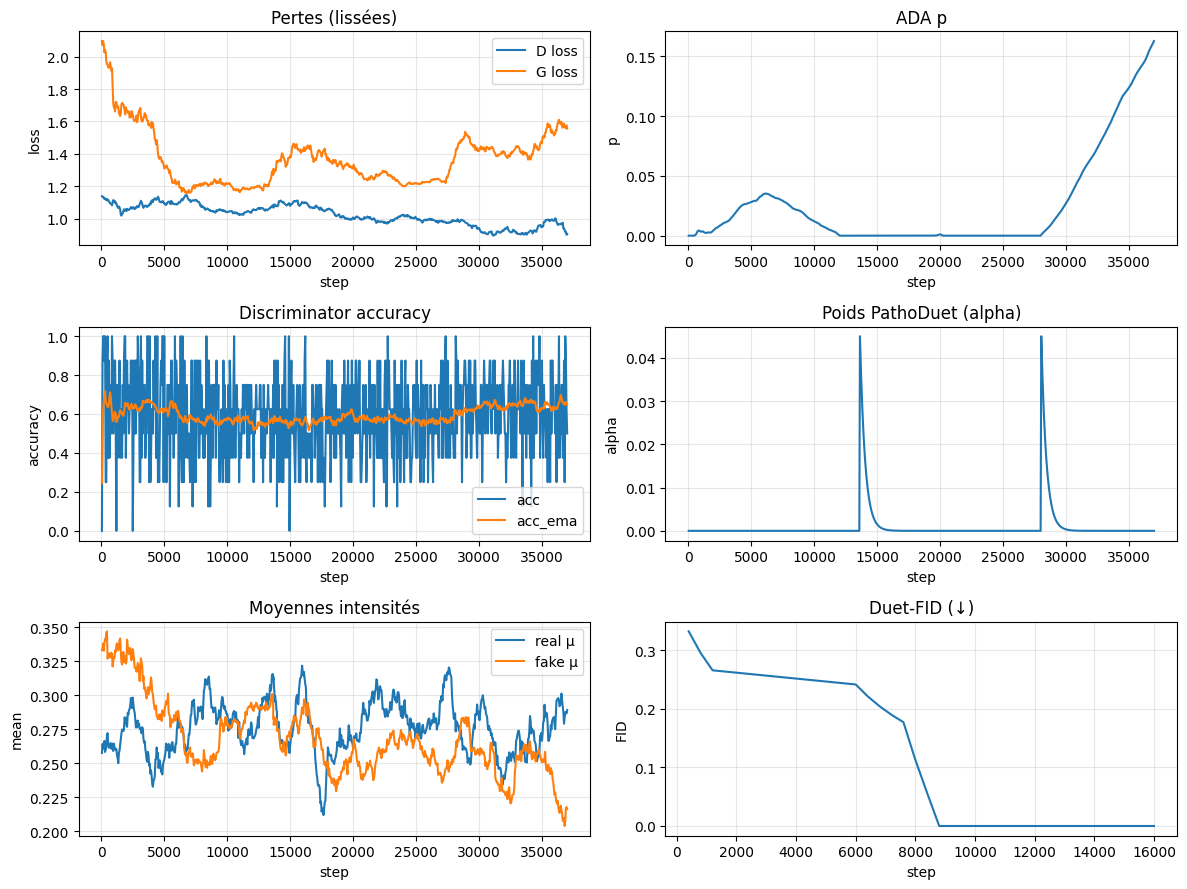

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Chargement métriques entraînement ---
df = pd.read_csv(METRICS_CSV).sort_values("step")

def smooth(s, w=31):
    if len(s) < w: return s
    return s.rolling(w, center=True, min_periods=1).mean()

# --- Chargement Duet-FID (optionnel) ---
duet_csv = METRICS_DIR / "duet_fid.csv"
fid_df = None
if duet_csv.exists():
    fid_df = pd.read_csv(duet_csv)
    # Harmonise le nom de la colonne 'step'
    if "global_step" in fid_df.columns and "step" not in fid_df.columns:
        fid_df = fid_df.rename(columns={"global_step": "step"})
    fid_df = fid_df.sort_values("step")

# --- Grille 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

# (1) Pertes lissées
ax1.plot(df["step"], smooth(df["d_loss"]), label="D loss")
ax1.plot(df["step"], smooth(df["g_loss"]), label="G loss")
ax1.set_title("Pertes (lissées)")
ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.legend(); ax1.grid(alpha=0.3)

# (2) ADA p
ax2.plot(df["step"], df["ada_p"])
ax2.set_title("ADA p")
ax2.set_xlabel("step"); ax2.set_ylabel("p")
ax2.grid(alpha=0.3)

# (3) Discriminator accuracy
ax3.plot(df["step"], df["acc"], label="acc")
ax3.plot(df["step"], df["acc_ema"], label="acc_ema")
ax3.set_title("Discriminator accuracy")
ax3.set_xlabel("step"); ax3.set_ylabel("accuracy")
ax3.legend(); ax3.grid(alpha=0.3)

# (4) Poids PathoDuet (alpha) si dispo
if "alpha" in df.columns:
    ax4.plot(df["step"], df["alpha"])
    ax4.set_title("Poids PathoDuet (alpha)")
    ax4.set_xlabel("step"); ax4.set_ylabel("alpha")
    ax4.grid(alpha=0.3)
else:
    ax4.axis("off")
    ax4.set_title("alpha indisponible", loc="left", fontstyle="italic")

# (5) Moyennes intensités
ax5.plot(df["step"], smooth(df["real_mu"]), label="real μ")
ax5.plot(df["step"], smooth(df["fake_mu"]), label="fake μ")
ax5.set_title("Moyennes intensités")
ax5.set_xlabel("step"); ax5.set_ylabel("mean")
ax5.legend(); ax5.grid(alpha=0.3)

# (6) Duet-FID (↓)
if fid_df is not None and "duet_fid" in fid_df.columns:
    ax6.plot(fid_df["step"], smooth(fid_df["duet_fid"], w=15))
    ax6.set_title("Duet-FID (↓)")
    ax6.set_xlabel("step"); ax6.set_ylabel("FID")
    ax6.grid(alpha=0.3)
else:
    ax6.axis("off")
    ax6.set_title("Duet-FID indisponible (pas de CSV)", loc="left", fontstyle="italic")

plt.tight_layout()
plt.show()


## 🎨 Génération conditionnelle par classe (référence image réelle)

Cette cellule charge le meilleur modèle et génère 4 images pour chaque classe, en utilisant une image réelle de référence depuis `CRC-VAL-HE-7K`.

📦 Chargement du meilleur modèle: /workspace/checkpoints/06b_cgan_ia/cgan_step030400.pt


/tmp/ipykernel_18630/3386073399.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path, map_location=DEVICE)


   Classes dans le checkpoint: 9
   fmap_base extrait du checkpoint: 512
   Mode: train (training=True) - comme pendant l'entraînement
✅ G_ema chargé avec succès

📋 Mapping des classes du modèle (basé sur SELECTED_CLASSES):
   ADI (Tissu adipeux) → index 0
   BACK (Arrière-plan (fond sans tissu)) → index 1
   DEB (Débris cellulaires / nécrose) → index 2
   LYM (Lymphocytes (infiltrat immunitaire)) → index 3
   MUC (Mucus (sécrétions)) → index 4
   MUS (Tissu musculaire lisse) → index 5
   NORM (Muqueuse colique normale) → index 6
   STR (Stroma associé au cancer) → index 7
   TUM (Épithélium adénocarcinomateux (tumeur)) → index 8

📁 Classes trouvées dans CRC-VAL-HE-7K (filtrées selon SELECTED_CLASSES):
   ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
   Nombre de classes: 9

🎨 Classe: ADI (index modèle: 0)
   Image de référence: ADI-TCGA-PCMHLCYY.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_ADI_idx0.png


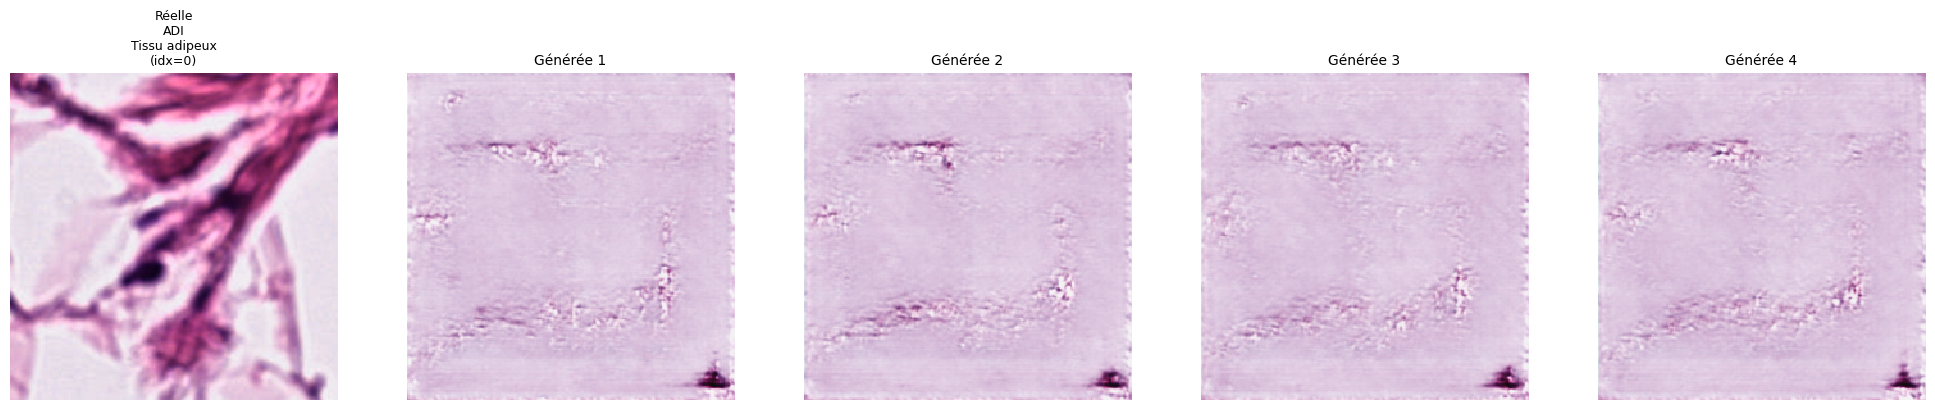


🎨 Classe: BACK (index modèle: 1)
   Image de référence: BACK-TCGA-LMGKFGMP.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_BACK_idx1.png


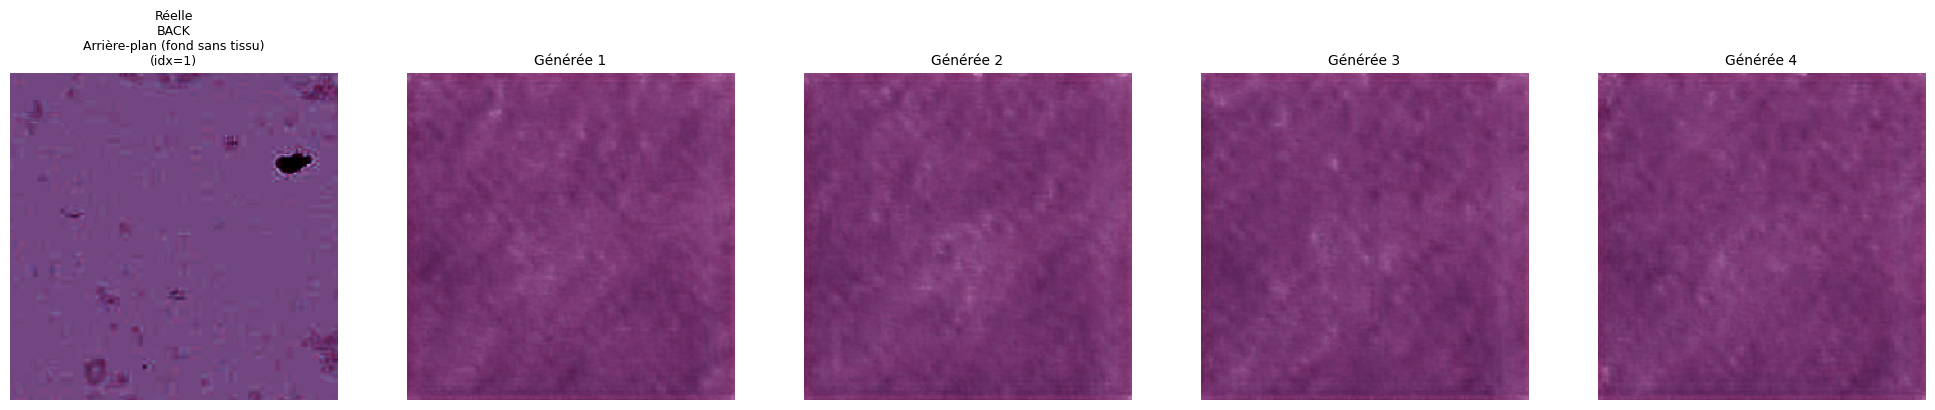


🎨 Classe: DEB (index modèle: 2)
   Image de référence: DEB-TCGA-NAEVQMTE.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_DEB_idx2.png


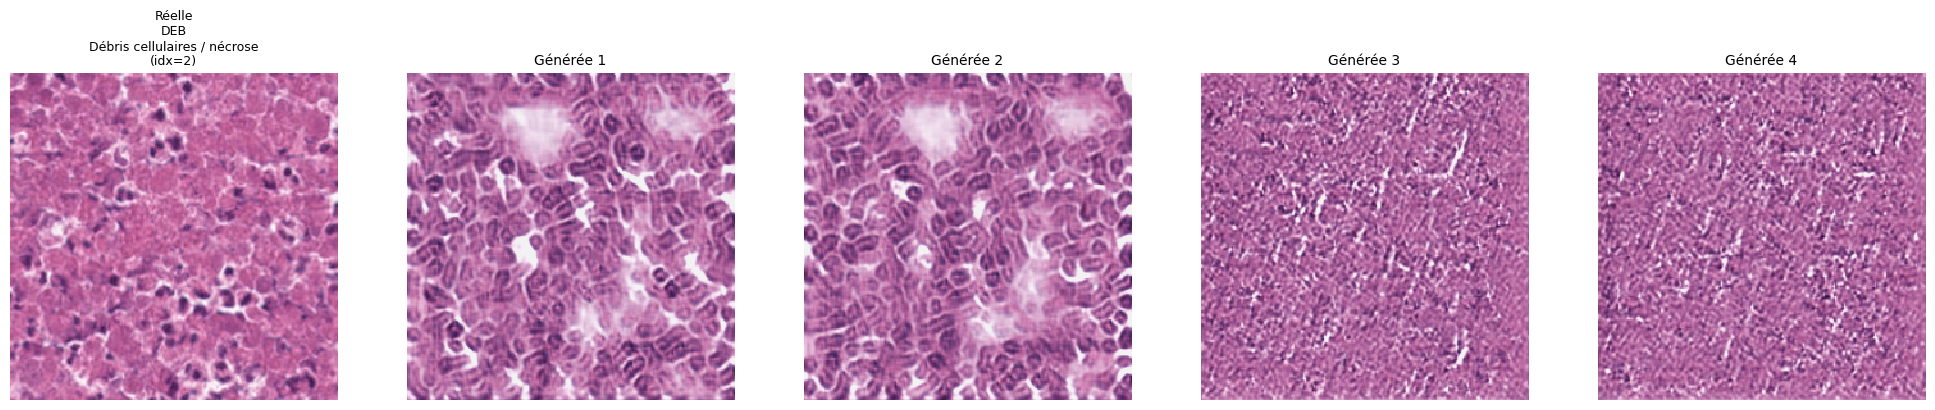


🎨 Classe: LYM (index modèle: 3)
   Image de référence: LYM-TCGA-EMDVYITM.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_LYM_idx3.png


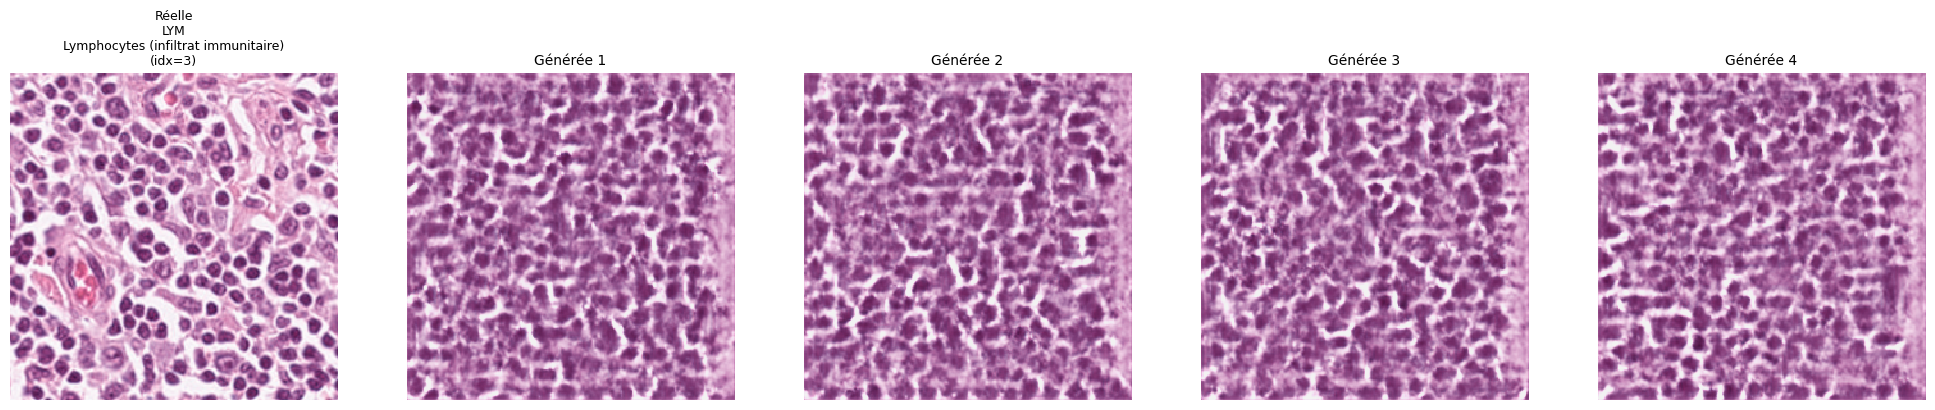


🎨 Classe: MUC (index modèle: 4)
   Image de référence: MUC-TCGA-IYCYYIHS.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_MUC_idx4.png


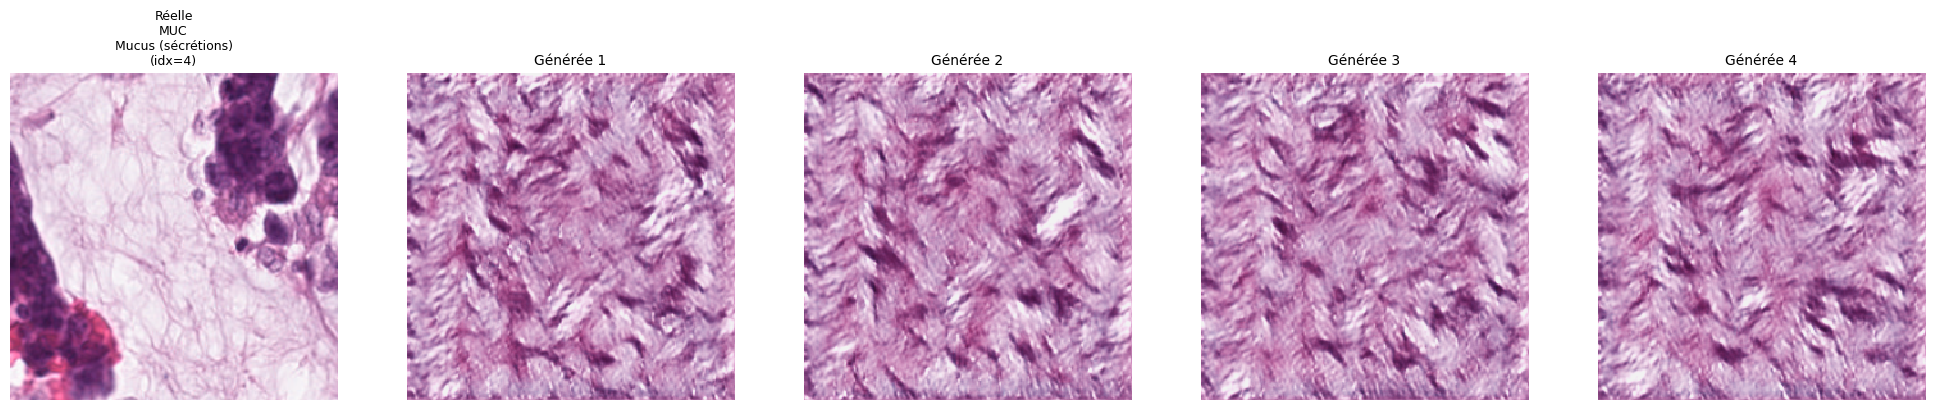


🎨 Classe: MUS (index modèle: 5)
   Image de référence: MUS-TCGA-PLFQTDIV.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_MUS_idx5.png


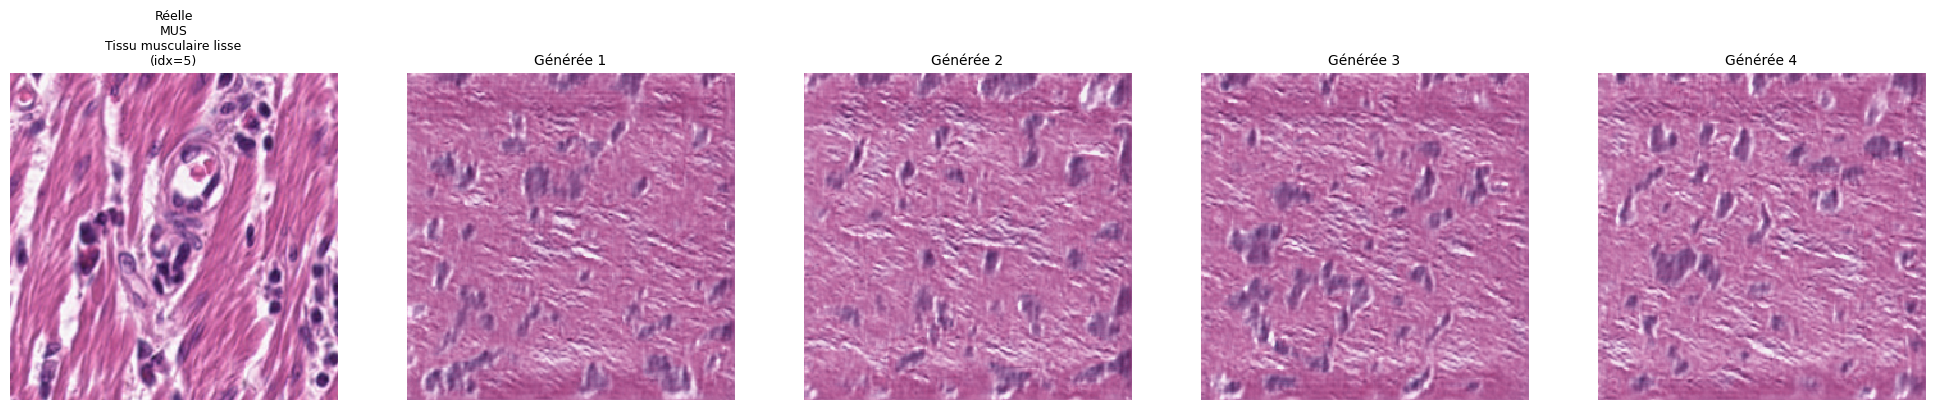


🎨 Classe: NORM (index modèle: 6)
   Image de référence: NORM-TCGA-HSYLGQQK.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_NORM_idx6.png


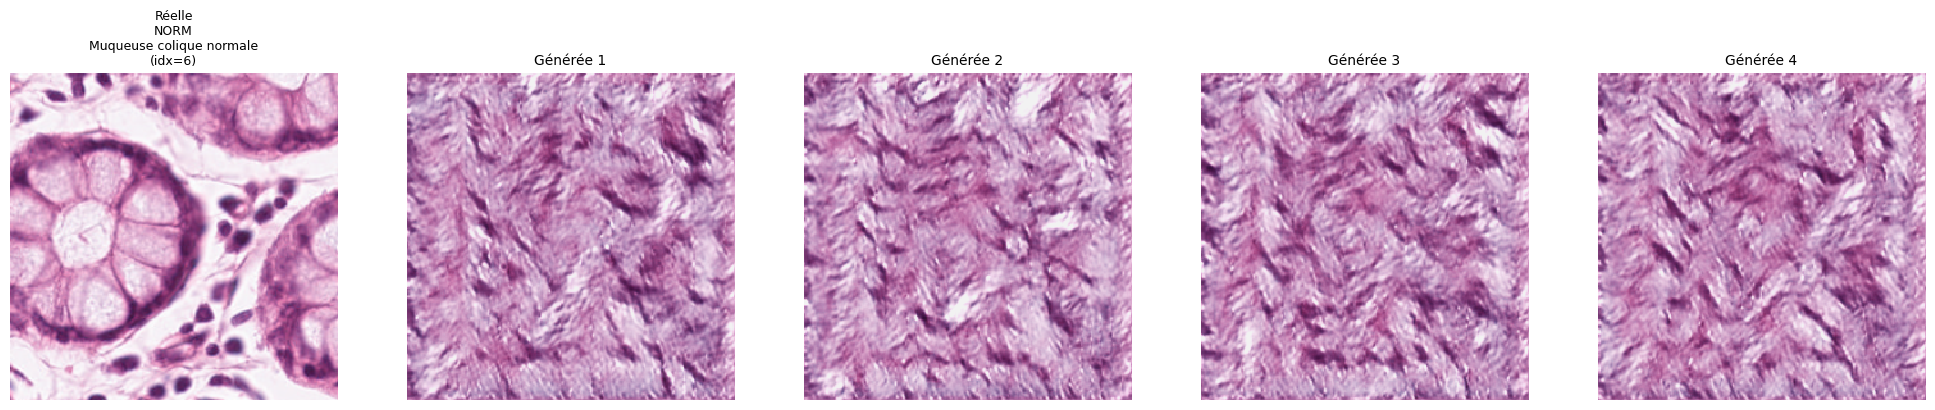


🎨 Classe: STR (index modèle: 7)
   Image de référence: STR-TCGA-WTIIGITV.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_STR_idx7.png


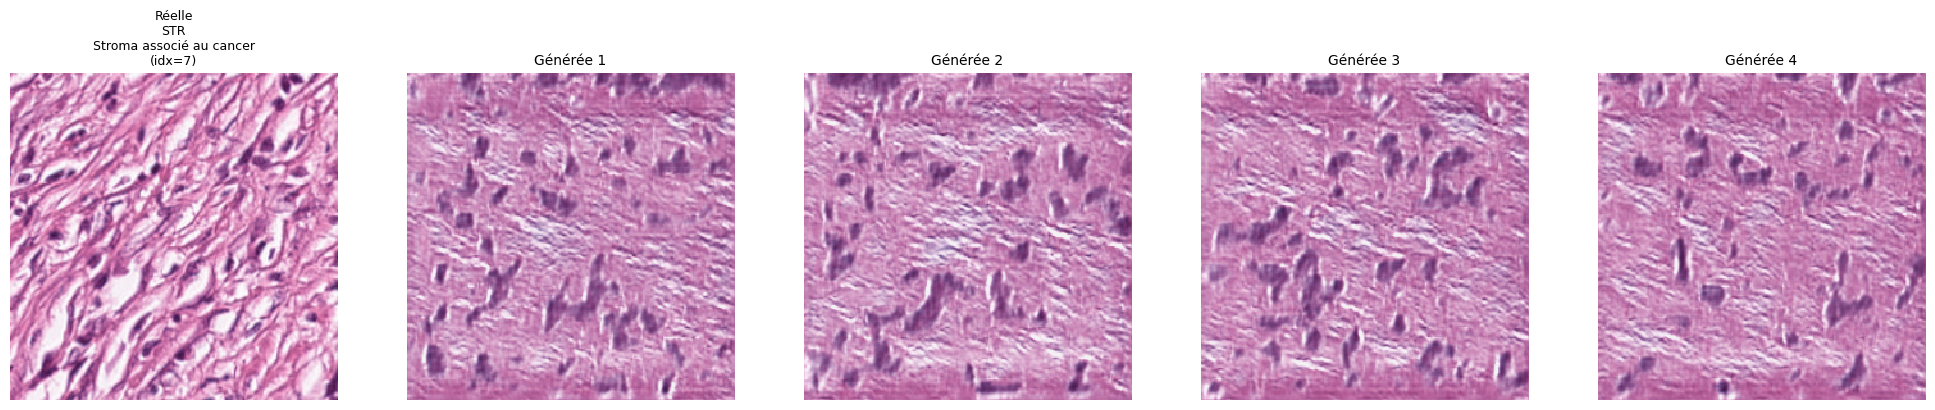


🎨 Classe: TUM (index modèle: 8)
   Image de référence: TUM-TCGA-CRCSQPQQ.tif
   💾 Sauvegardé: /workspace/samples/06b_cgan_ia/conditional_generation/class_TUM_idx8.png


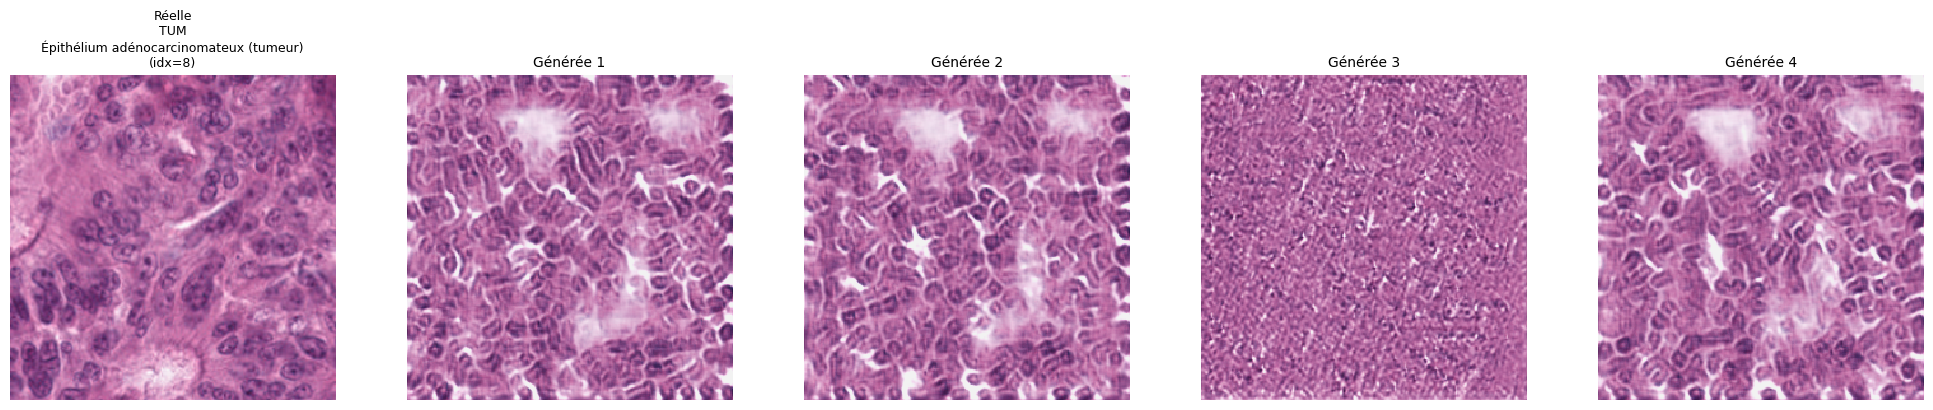


✅ Génération terminée ! Résultats dans: /workspace/samples/06b_cgan_ia/conditional_generation


In [15]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np

# Chemin vers le meilleur modèle
# best_model_path = MODELS_DIR / "cgan_best_model.pt"
best_model_path = CHECKPOINTS_DIR / "cgan_step030400.pt"

if not best_model_path.exists():
    print(f"⚠️  Modèle introuvable: {best_model_path}")
    print(f"   Vérifiez que le meilleur modèle existe dans: {MODELS_DIR}")
else:
    print(f"📦 Chargement du meilleur modèle: {best_model_path}")
    ckpt = torch.load(best_model_path, map_location=DEVICE)
    
    # Charger G_ema (meilleur pour l'inférence)
    num_classes_ckpt = ckpt.get("num_classes", 1)
    print(f"   Classes dans le checkpoint: {num_classes_ckpt}")
    
    # Reconstruire G_ema avec la bonne architecture
    # Extraire fmap_base depuis le checkpoint (comme dans l'entraînement)
    try:
        # Le const est la première dimension du paramètre const
        const_key = [k for k in ckpt["G_ema"].keys() if "const" in k][0]
        fmap_base_ckpt = ckpt["G_ema"][const_key].shape[1]
        print(f"   fmap_base extrait du checkpoint: {fmap_base_ckpt}")
    except Exception as e:
        print(f"   ⚠️  Impossible d'extraire fmap_base du checkpoint: {e}")
        print(f"   Utilisation de FMAP_BASE={FMAP_BASE} par défaut")
        fmap_base_ckpt = FMAP_BASE
    
    G_ema_inference = Generator(
        z_dim=Z_DIM, 
        w_dim=Z_DIM, 
        img_res=IMAGE_SIZE, 
        fmap_base=fmap_base_ckpt, 
        num_classes=num_classes_ckpt
    ).to(DEVICE)
    G_ema_inference.load_state_dict(ckpt["G_ema"])
    requires_grad(G_ema_inference, False)
    # ✅ IMPORTANT : Ne PAS mettre en eval() car pendant l'entraînement G_ema reste en train()
    # Le Generator utilise if self.training: pour l'injection de bruit et le style mixing
    # Si on met en eval(), le bruit n'est pas injecté et les images sont différentes
    G_ema_inference.train()  # Comme pendant l'entraînement pour les samples
    print(f"   Mode: train (training={G_ema_inference.training}) - comme pendant l'entraînement")
    print(f"✅ G_ema chargé avec succès")
    
    # ✅ IMPORTANT : Créer le mapping des classes basé sur SELECTED_CLASSES
    # Le dataset a été créé avec SELECTED_CLASSES, donc les indices sont 0, 1, 2, ... dans l'ordre de SELECTED_CLASSES
    # On utilise directement SELECTED_CLASSES avec les helpers de class_mappings.py
    if SELECTED_CLASSES is None:
        # Si SELECTED_CLASSES est None, utiliser toutes les classes disponibles dans class_labels
        selected_classes_list = list(class_labels.keys())
    else:
        selected_classes_list = SELECTED_CLASSES
    
    # Créer class_to_idx basé sur l'ordre de SELECTED_CLASSES (indices 0, 1, 2, ...)
    class_to_idx = {class_name: idx for idx, class_name in enumerate(selected_classes_list)}
    idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
    
    # ✅ Utiliser make_idx_mappings pour créer les mappings d'affichage
    idx_to_name, idx_to_color, name_to_color = make_idx_mappings(class_to_idx)
    
    # Afficher le mapping des classes
    print(f"\n📋 Mapping des classes du modèle (basé sur SELECTED_CLASSES):")
    for class_name, idx in sorted(class_to_idx.items(), key=lambda x: x[1]):
        label = class_labels.get(class_name, class_name)
        print(f"   {class_name} ({label}) → index {idx}")
    
    # Chemin vers les images de référence
    val_dir = DATA_ROOT / "CRC-VAL-HE-7K"
    
    if not val_dir.exists():
        print(f"\n⚠️  Dossier introuvable: {val_dir}")
    else:
        # ✅ Filtrer uniquement les classes sélectionnées (SELECTED_CLASSES)
        selected_classes_set = set(SELECTED_CLASSES) if SELECTED_CLASSES else set(class_to_idx.keys())
        
        # Parcourir les sous-dossiers et filtrer selon SELECTED_CLASSES
        class_dirs = []
        for d in sorted(val_dir.iterdir()):
            if d.is_dir() and d.name in selected_classes_set:
                class_dirs.append(d)
    
    print(f"\n📁 Classes trouvées dans CRC-VAL-HE-7K (filtrées selon SELECTED_CLASSES):")
    print(f"   {[d.name for d in class_dirs]}")
    print(f"   Nombre de classes: {len(class_dirs)}")
    
    if len(class_dirs) == 0:
        print(f"\n⚠️  Aucune classe correspondant à SELECTED_CLASSES={SELECTED_CLASSES} trouvée dans {val_dir}")
    else:
        # Créer le dossier de sortie
        output_dir = SAMPLES_DIR / "conditional_generation"
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Transform pour charger les images réelles
        transform = T.Compose([
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
        ])
        
        # Pour chaque classe sélectionnée
        for class_dir in class_dirs:
            class_name = class_dir.name
            
            # ✅ Utiliser le mapping correct : obtenir l'index du modèle pour cette classe
            if class_name not in class_to_idx:
                print(f"\n⚠️  Classe {class_name} non trouvée dans le mapping du modèle (ignorée)")
                continue
            
            model_class_idx = class_to_idx[class_name]
            
            # Vérifier que l'index est valide pour le modèle
            if model_class_idx >= num_classes_ckpt:
                print(f"\n⚠️  Classe {class_name} a l'index {model_class_idx} mais le modèle n'a que {num_classes_ckpt} classes (ignorée)")
                continue
            
            # Trouver une image réelle dans ce dossier
            image_files = list(class_dir.glob("*.tif")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
            
            if not image_files:
                print(f"\n⚠️  Aucune image trouvée dans {class_dir}")
                continue
            
            # Prendre une image aléatoire
            ref_image_path = random.choice(image_files)
            print(f"\n🎨 Classe: {class_name} (index modèle: {model_class_idx})")
            print(f"   Image de référence: {ref_image_path.name}")
            
            # Charger l'image de référence
            ref_img = Image.open(ref_image_path).convert("RGB")
            ref_tensor = transform(ref_img).unsqueeze(0).to(DEVICE)
            
            # ✅ Générer 4 images conditionnées sur cette classe avec le BON index
            with torch.no_grad():
                # ✅ IMPORTANT : Le modèle doit rester en mode train() pour injecter le bruit
                # comme pendant l'entraînement (G_ema n'est jamais en eval() pendant l'entraînement)
                G_ema_inference.train()  # S'assurer qu'on est en mode train() pour le bruit
                z_gen = torch.randn(4, Z_DIM, device=DEVICE)
                y_gen = torch.full((4,), model_class_idx, dtype=torch.long, device=DEVICE)
                fake_images = G_ema_inference(z_gen, y_gen).clamp(-1, 1)
            
            # ✅ IMPORTANT : Utiliser vutils.save_image() comme pendant l'entraînement pour éviter le flou
            # Créer un tenseur combiné : image réelle + 4 images générées
            # Normaliser à [0, 1] comme pendant l'entraînement
            ref_normalized = (ref_tensor[0].clamp(-1, 1) + 1) * 0.5  # [0, 1]
            fake_normalized = (fake_images.clamp(-1, 1) + 1) * 0.5  # [0, 1]
            
            # Combiner : [réelle, fake1, fake2, fake3, fake4]
            combined_images = torch.cat([ref_normalized.unsqueeze(0), fake_normalized], dim=0)
            
            # Sauvegarder avec vutils.save_image() (comme pendant l'entraînement)
            output_path = output_dir / f"class_{class_name}_idx{model_class_idx}.png"
            import torchvision.utils as vutils
            vutils.save_image(combined_images, str(output_path), nrow=5, padding=2, normalize=False)
            print(f"   💾 Sauvegardé: {output_path}")
            
            # Afficher aussi avec matplotlib pour visualisation (mais sauvegarde avec vutils)
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            class_label = class_labels.get(class_name, class_name)
            
            # Image réelle
            ref_display = ref_normalized.cpu().permute(1, 2, 0)
            axes[0].imshow(ref_display, interpolation='nearest')
            axes[0].set_title(f"Réelle\n{class_name}\n{class_label}\n(idx={model_class_idx})", fontsize=9)
            axes[0].axis("off")
            
            # 4 images générées
            for i in range(4):
                fake_display = fake_normalized[i].cpu().permute(1, 2, 0)
                axes[i+1].imshow(fake_display, interpolation='nearest')
                axes[i+1].set_title(f"Générée {i+1}", fontsize=10)
                axes[i+1].axis("off")
            
            plt.tight_layout()
            plt.show()
            
        print(f"\n✅ Génération terminée ! Résultats dans: {output_dir}")


## 📊 Évaluation complète : FID, LPIPS et Classification

Cette cellule calcule les métriques FID et LPIPS entre les images réelles et synthétiques,
puis évalue la performance d'un modèle CNN de classification sur les deux ensembles.


In [16]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm
import sys

# Ajout du chemin des métriques
if str(PROJECT_ROOT / "metrics") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "metrics"))

from fid_lpips_eval import FIDLPIPSEvaluator, run_eval_experiment
from cnn_eval import run_eval_split, export_predictions
from histo_dataset import HistoDataset
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils

# Configuration
N_SYNTH_PER_CLASS = 200  # Nombre d'images synthétiques à générer par classe
MAX_IMAGES_FID = 200     # Nombre max d'images par classe pour FID/LPIPS
BATCH_SIZE_EVAL = 32     # Batch size pour l'évaluation CNN

print("✅ Imports terminés")
print(f"   - Images synthétiques par classe: {N_SYNTH_PER_CLASS}")
print(f"   - Max images pour FID/LPIPS: {MAX_IMAGES_FID}")

# Vérifier que G_ema_inference existe (doit être chargé dans la cellule précédente)
if 'G_ema_inference' not in globals():
    print("⚠️  G_ema_inference non trouvé. Chargement du meilleur modèle...")
    best_model_path = MODELS_DIR / "cgan_best_model.pt"
    if not best_model_path.exists():
        raise FileNotFoundError(f"Modèle introuvable: {best_model_path}")
    
    ckpt = torch.load(best_model_path, map_location=DEVICE)
    num_classes_ckpt = ckpt.get("num_classes", 9)
    
    # Extraire fmap_base
    try:
        const_key = [k for k in ckpt["G_ema"].keys() if "const" in k][0]
        fmap_base_ckpt = ckpt["G_ema"][const_key].shape[1]
    except Exception:
        fmap_base_ckpt = FMAP_BASE if 'FMAP_BASE' in globals() else 512
    
    G_ema_inference = Generator(
        z_dim=Z_DIM, w_dim=Z_DIM, img_res=IMAGE_SIZE,
        fmap_base=fmap_base_ckpt, num_classes=num_classes_ckpt
    ).to(DEVICE)
    G_ema_inference.load_state_dict(ckpt["G_ema"])
    for p in G_ema_inference.parameters():
        p.requires_grad_(False)
    G_ema_inference.train()  # Mode train pour injection de bruit
    print("✅ G_ema_inference chargé")

# Créer les dossiers pour les images synthétiques organisées par classe
synth_root = SAMPLES_DIR / "eval_synthetic"
synth_root.mkdir(parents=True, exist_ok=True)

# Créer les dossiers par classe
if SELECTED_CLASSES is None:
    selected_classes_list = list(class_to_idx.keys()) if 'class_to_idx' in globals() else list(class_labels.keys())
else:
    selected_classes_list = SELECTED_CLASSES

for class_name in selected_classes_list:
    (synth_root / class_name).mkdir(exist_ok=True)

print(f"\n📁 Dossiers créés dans: {synth_root}")
print(f"   Classes: {selected_classes_list}")

# Générer les images synthétiques par classe
print(f"\n🎨 Génération de {N_SYNTH_PER_CLASS} images synthétiques par classe...")
G_ema_inference.train()  # Mode train pour injection de bruit (comme pendant l'entraînement)

with torch.no_grad():
    for class_name in tqdm(selected_classes_list, desc="Génération par classe"):
        if class_name not in class_to_idx:
            print(f"⚠️  Classe {class_name} non trouvée dans class_to_idx, ignorée")
            continue
        
        class_idx = class_to_idx[class_name]
        class_dir = synth_root / class_name
        
        # Générer par batch
        n_batches = (N_SYNTH_PER_CLASS + BATCH_SIZE_EVAL - 1) // BATCH_SIZE_EVAL
        img_count = 0
        
        for batch_idx in range(n_batches):
            batch_size = min(BATCH_SIZE_EVAL, N_SYNTH_PER_CLASS - img_count)
            if batch_size <= 0:
                break
            
            z = torch.randn(batch_size, Z_DIM, device=DEVICE)
            y = torch.full((batch_size,), class_idx, dtype=torch.long, device=DEVICE)
            
            fake_images = G_ema_inference(z, y).clamp(-1, 1)
            fake_normalized = (fake_images + 1) * 0.5  # [0, 1]
            
            # Sauvegarder chaque image
            for i in range(batch_size):
                img_path = class_dir / f"synth_{img_count:05d}.png"
                vutils.save_image(fake_normalized[i:i+1], str(img_path), normalize=False)
                img_count += 1

print(f"✅ {N_SYNTH_PER_CLASS} images synthétiques générées par classe dans: {synth_root}")

# Préparer le dossier des images réelles (utiliser CRC-VAL-HE-7K ou un subset de train)
real_root = DATA_ROOT / "CRC-VAL-HE-7K"
if not real_root.exists():
    print(f"⚠️  {real_root} introuvable, utilisation de NCT-CRC-HE-100K/train")
    real_root = DATA_ROOT / "NCT-CRC-HE-100K"

print(f"\n📊 Calcul des métriques FID et LPIPS...")
print(f"   Réel: {real_root}")
print(f"   Synthétique: {synth_root}")

# Calculer FID et LPIPS
try:
    fid_lpips_df = run_eval_experiment(
        name="cgan_eval",
        real_root=real_root,
        gen_root=synth_root,
        classes=selected_classes_list,
        max_images_per_class=MAX_IMAGES_FID,
        lpips_pairs=50,
        seed=42,
        save_dir=METRICS_DIR,
    )
    
    print("\n" + "="*60)
    print("📊 RÉSULTATS FID et LPIPS")
    print("="*60)
    print(fid_lpips_df.to_string(index=False))
    print("="*60)
    
    # Afficher les moyennes
    print(f"\n📈 Moyennes globales:")
    print(f"   FID moyen: {fid_lpips_df['FID'].mean():.3f}")
    print(f"   LPIPS moyen: {fid_lpips_df['LPIPS'].mean():.3f}")
    
except Exception as e:
    print(f"❌ Erreur lors du calcul FID/LPIPS: {e}")
    import traceback
    traceback.print_exc()
    fid_lpips_df = None


✅ Imports terminés
   - Images synthétiques par classe: 200
   - Max images pour FID/LPIPS: 200

📁 Dossiers créés dans: /workspace/samples/06b_cgan_ia/eval_synthetic
   Classes: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

🎨 Génération de 200 images synthétiques par classe...


Génération par classe: 100%|██████████| 9/9 [00:35<00:00,  3.99s/it]


✅ 200 images synthétiques générées par classe dans: /workspace/samples/06b_cgan_ia/eval_synthetic

📊 Calcul des métriques FID et LPIPS...
   Réel: /workspace/data/CRC-VAL-HE-7K
   Synthétique: /workspace/samples/06b_cgan_ia/eval_synthetic
🎯 Expérience : cgan_eval
📁 real_root = /workspace/data/CRC-VAL-HE-7K
📁 gen_root  = /workspace/samples/06b_cgan_ia/eval_synthetic
📦 classes évaluées : ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
🎲 seed = 42
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
✅ Initialisé : CRC-VAL-HE-7K vs eval_synthetic
📂 Classes évaluées : ADI, BACK, DEB, LYM, MUC, MUS, NORM, STR, TUM
💾 Rapport : /workspace/artifacts/06b_cgan_ia/metrics/CRC-VAL-HE-7K_eval_synthetic.csv


Évaluation multi-classes: 100%|██████████| 9/9 [01:46<00:00, 11.84s/it]


✅ Rapport enregistré : /workspace/artifacts/06b_cgan_ia/metrics/CRC-VAL-HE-7K_eval_synthetic.csv
💾 Résultats sauvegardés → /workspace/artifacts/06b_cgan_ia/metrics/cgan_eval_metrics.csv

📊 RÉSULTATS FID et LPIPS
class  n_real  n_synth        FID  KID_mean  KID_std    LPIPS FID_UNI experiment  max_images_per_class  lpips_pairs
  ADI     200      200 414.950785  0.544850 0.012592 0.498758    None  cgan_eval                   200           50
 BACK     200      200 299.910694  0.356472 0.013330 0.280223    None  cgan_eval                   200           50
  DEB     200      200 172.593454  0.128035 0.015149 0.407957    None  cgan_eval                   200           50
  LYM     200      200 149.235783  0.168252 0.015892 0.320191    None  cgan_eval                   200           50
  MUC     200      200 310.766850  0.358088 0.013619 0.449923    None  cgan_eval                   200           50
  MUS     200      200 219.639496  0.233449 0.013835 0.436963    None  cgan_eval           

## 🧠 Évaluation de classification CNN

Cette cellule charge un modèle CNN de classification et l'évalue sur les images réelles et synthétiques.


In [17]:
# Créer un dataset personnalisé pour les images dans les dossiers
class FolderDataset(Dataset):
    """Dataset pour charger des images depuis des dossiers organisés par classe."""
    def __init__(self, root_dir, class_to_idx, transform=None, pixel_range="imagenet"):
        self.root_dir = Path(root_dir)
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.pixel_range = pixel_range
        self.samples = []
        
        # Parcourir les dossiers de classes
        for class_name, class_idx in class_to_idx.items():
            class_dir = self.root_dir / class_name
            if not class_dir.exists():
                continue
            
            # Trouver toutes les images
            image_files = list(class_dir.glob("*.png")) + list(class_dir.glob("*.tif")) + list(class_dir.glob("*.jpg"))
            for img_path in image_files:
                self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Charger l'image
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        else:
            # Transform par défaut
            transform_default = T.Compose([
                T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                T.ToTensor(),
            ])
            img = transform_default(img)
            
            # Normalisation selon pixel_range
            if self.pixel_range == "imagenet":
                img = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            elif self.pixel_range == "-1_1":
                img = img * 2.0 - 1.0
        
        return img, label, str(img_path)

# Chercher un modèle CNN entraîné
print("🔍 Recherche d'un modèle CNN de classification...")
cnn_model_paths = list(MODELS_DIR.glob("*_best.pt"))
if not cnn_model_paths:
    print("⚠️  Aucun modèle CNN trouvé dans MODELS_DIR")
    print("   Les modèles CNN sont généralement sauvegardés comme: <model_name>_best.pt")
    print(f"   Dossier recherché: {MODELS_DIR}")
    print("\n   Pour entraîner un modèle CNN, exécutez le notebook 02_baseline_cnn.ipynb")
    cnn_model = None
else:
    # Prendre le premier modèle trouvé (ou vous pouvez spécifier un nom précis)
    cnn_model_path = cnn_model_paths[0]
    print(f"📦 Chargement du modèle: {cnn_model_path.name}")
    
    # Charger le modèle (on doit connaître l'architecture)
    # Par défaut, on essaie MobileNetV2 (architecture courante dans 02_baseline_cnn)
    try:
        import torchvision.models as models
        from torchvision.models import MobileNet_V2_Weights
        
        # Créer le modèle
        cnn_model = models.mobilenet_v2(weights=None)
        num_classes_cnn = len(selected_classes_list)
        cnn_model.classifier[1] = torch.nn.Linear(cnn_model.last_channel, num_classes_cnn)
        
        # Charger les poids
        ckpt = torch.load(cnn_model_path, map_location=DEVICE, weights_only=True)
        if isinstance(ckpt, dict) and "model" in ckpt:
            state_dict = ckpt["model"]
        elif isinstance(ckpt, dict) and "state_dict" in ckpt:
            state_dict = ckpt["state_dict"]
        else:
            state_dict = ckpt
        
        # Nettoyer les clés si nécessaire
        clean_state_dict = {}
        for k, v in state_dict.items():
            new_k = k.replace("module.", "").replace("model.", "")
            clean_state_dict[new_k] = v
        
        cnn_model.load_state_dict(clean_state_dict, strict=False)
        cnn_model = cnn_model.to(DEVICE)
        cnn_model.eval()
        print(f"✅ Modèle CNN chargé: {cnn_model_path.name}")
        print(f"   Classes: {num_classes_cnn}")
        
    except Exception as e:
        print(f"❌ Erreur lors du chargement du modèle CNN: {e}")
        import traceback
        traceback.print_exc()
        cnn_model = None

if cnn_model is not None:
    # Créer les datasets et dataloaders pour images réelles et synthétiques
    print("\n📂 Création des datasets...")
    
    # Transform pour les images (normalisation ImageNet)
    transform_eval = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset réel (utiliser CRC-VAL-HE-7K si disponible)
    real_val_dir = DATA_ROOT / "CRC-VAL-HE-7K"
    if not real_val_dir.exists():
        real_val_dir = DATA_ROOT / "NCT-CRC-HE-100K"
    
    ds_real = FolderDataset(real_val_dir, class_to_idx, transform=transform_eval, pixel_range="imagenet")
    print(f"   Dataset réel: {len(ds_real)} images")
    
    # Dataset synthétique
    ds_synth = FolderDataset(synth_root, class_to_idx, transform=transform_eval, pixel_range="imagenet")
    print(f"   Dataset synthétique: {len(ds_synth)} images")
    
    # Créer les dataloaders
    loader_real = DataLoader(
        ds_real, batch_size=BATCH_SIZE_EVAL, shuffle=False,
        num_workers=0, pin_memory=(DEVICE == "cuda")
    )
    
    loader_synth = DataLoader(
        ds_synth, batch_size=BATCH_SIZE_EVAL, shuffle=False,
        num_workers=0, pin_memory=(DEVICE == "cuda")
    )
    
    # Évaluer sur les images réelles
    print("\n" + "="*60)
    print("🧠 ÉVALUATION CNN - Images RÉELLES")
    print("="*60)
    
    try:
        df_real, report_real = run_eval_split(
            model=cnn_model,
            dataloader=loader_real,
            device=DEVICE,
            out_dir=OUTPUTS_DIR / "cnn_eval_real",
            model_name="cnn_eval_real",
            split="real",
            class_to_idx=class_to_idx,
            fit_temperature_on_val=False,
            make_plots=True
        )
        
        print(f"\n📊 Résultats sur images RÉELLES:")
        print(f"   Accuracy: {report_real.acc_micro:.4f}")
        print(f"   F1-score (macro): {report_real.f1_macro:.4f}")
        print(f"   ECE (raw): {report_real.ece_raw:.4f}")
        print(f"\n{report_real.classification_report}")
        
    except Exception as e:
        print(f"❌ Erreur lors de l'évaluation sur images réelles: {e}")
        import traceback
        traceback.print_exc()
        report_real = None
    
    # Évaluer sur les images synthétiques
    print("\n" + "="*60)
    print("🧠 ÉVALUATION CNN - Images SYNTHÉTIQUES")
    print("="*60)
    
    try:
        df_synth, report_synth = run_eval_split(
            model=cnn_model,
            dataloader=loader_synth,
            device=DEVICE,
            out_dir=OUTPUTS_DIR / "cnn_eval_synth",
            model_name="cnn_eval_synth",
            split="synthetic",
            class_to_idx=class_to_idx,
            fit_temperature_on_val=False,
            make_plots=True
        )
        
        print(f"\n📊 Résultats sur images SYNTHÉTIQUES:")
        print(f"   Accuracy: {report_synth.acc_micro:.4f}")
        print(f"   F1-score (macro): {report_synth.f1_macro:.4f}")
        print(f"   ECE (raw): {report_synth.ece_raw:.4f}")
        print(f"\n{report_synth.classification_report}")
        
    except Exception as e:
        print(f"❌ Erreur lors de l'évaluation sur images synthétiques: {e}")
        import traceback
        traceback.print_exc()
        report_synth = None
    
    # Comparaison
    if report_real is not None and report_synth is not None:
        print("\n" + "="*60)
        print("📈 COMPARAISON RÉEL vs SYNTHÉTIQUE")
        print("="*60)
        print(f"{'Métrique':<25} {'Réel':<15} {'Synthétique':<15} {'Différence':<15}")
        print("-" * 70)
        print(f"{'Accuracy':<25} {report_real.acc_micro:<15.4f} {report_synth.acc_micro:<15.4f} {abs(report_real.acc_micro - report_synth.acc_micro):<15.4f}")
        print(f"{'F1-score (macro)':<25} {report_real.f1_macro:<15.4f} {report_synth.f1_macro:<15.4f} {abs(report_real.f1_macro - report_synth.f1_macro):<15.4f}")
        print(f"{'ECE (raw)':<25} {report_real.ece_raw:<15.4f} {report_synth.ece_raw:<15.4f} {abs(report_real.ece_raw - report_synth.ece_raw):<15.4f}")
        print("="*60)
        
        # Calculer le ratio de performance
        acc_ratio = report_synth.acc_micro / report_real.acc_micro if report_real.acc_micro > 0 else 0
        f1_ratio = report_synth.f1_macro / report_real.f1_macro if report_real.f1_macro > 0 else 0
        
        print(f"\n📊 Ratio de performance (Synthétique / Réel):")
        print(f"   Accuracy: {acc_ratio:.2%}")
        print(f"   F1-score: {f1_ratio:.2%}")
        
        if acc_ratio > 0.8:
            print("   ✅ Les images synthétiques permettent une performance proche des images réelles")
        elif acc_ratio > 0.6:
            print("   ⚠️  Les images synthétiques permettent une performance modérée")
        else:
            print("   ❌ Les images synthétiques ont une performance significativement inférieure")

else:
    print("\n⚠️  Évaluation CNN ignorée (modèle non disponible)")


🔍 Recherche d'un modèle CNN de classification...
📦 Chargement du modèle: mobilenetv2_best.pt
✅ Modèle CNN chargé: mobilenetv2_best.pt
   Classes: 9

📂 Création des datasets...
   Dataset réel: 7180 images
   Dataset synthétique: 1800 images

🧠 ÉVALUATION CNN - Images RÉELLES
[OK] export → /workspace/outputs/06b_cgan_ia/cnn_eval_real/cnn_eval_real_preds_real.csv  (7180 lignes)

📊 Résultats sur images RÉELLES:
   Accuracy: 0.8712
   F1-score (macro): 0.8219
   ECE (raw): 0.1751

              precision    recall  f1-score   support

         ADI      0.953     0.979     0.966      1338
        BACK      0.835     0.999     0.910       847
         DEB      0.777     0.431     0.554       339
         LYM      0.899     0.997     0.945       634
         MUC      0.985     0.806     0.886      1035
         MUS      0.733     0.824     0.776       592
        NORM      0.719     0.969     0.825       741
         STR      0.701     0.556     0.620       421
         TUM      0.991     0.8

## 📚 Explication du calcul Duet-FID et pourquoi il peut être négatif

Cette cellule explique comment le Duet-FID est calculé et pourquoi il peut parfois être négatif (ce qui est anormal).


In [14]:
"""
📚 EXPLICATION DU CALCUL DUET-FID

Le Duet-FID est une variante de la distance de Fréchet (Fréchet Inception Distance) qui utilise
les features du modèle PathoDuet au lieu de l'Inception Network.

FORMULE STANDARD DE LA DISTANCE DE FRÉCHET:
-------------------------------------------
FID = ||μ₁ - μ₂||² + Tr(C₁ + C₂ - 2√(C₁C₂))

Où:
- μ₁, μ₂ : moyennes des features (vecteurs de dimension d=768 pour PathoDuet)
- C₁, C₂ : matrices de covariance (d×d)
- √(C₁C₂) : racine carrée matricielle du produit C₁C₂
- Tr() : trace de la matrice

PROBLÈME DANS L'IMPLÉMENTATION ACTUELLE:
----------------------------------------
Le code calcule:
1. C1h = √C₁ (racine carrée de C₁)
2. C2h = √C₂ (racine carrée de C₂)  
3. P = (C1h @ C2h) @ (C1h @ C2h) = (C1h @ C2h)²
4. sqrtP = √P

⚠️ PROBLÈME: (C1h @ C2h)² ≠ C₁C₂ en général !

La formule correcte devrait calculer directement √(C₁C₂) sans passer par les racines carrées individuelles.

POURQUOI LE FID PEUT ÊTRE NÉGATIF:
----------------------------------
Le FID peut être négatif si:
Tr(C₁ + C₂ - 2√(C₁C₂)) < -||μ₁ - μ₂||²

Cela peut arriver quand:
1. Erreurs numériques dans le calcul de √(C₁C₂)
2. Matrices de covariance mal conditionnées (proche de la singularité)
3. Calcul incorrect de √(C₁C₂) comme dans l'implémentation actuelle
4. Petits échantillons (n_real, n_fake) → covariance instable

En théorie, le FID devrait toujours être ≥ 0 car c'est une distance.
"""

import torch
import numpy as np

# Afficher la fonction actuelle
print("="*70)
print("FONCTION ACTUELLE (dans le notebook):")
print("="*70)
print("""
def _fre(mu1, c1, mu2, c2):
    m1 = mu1.double()
    m2 = mu2.double()
    C1 = c1.double()
    C2 = c2.double()
    diff = (m1 - m2)
    
    # Calcul des racines carrées individuelles
    eva1, eve1 = torch.linalg.eigh(C1 + 1e-6*torch.eye(C1.shape[0]))
    eva2, eve2 = torch.linalg.eigh(C2 + 1e-6*torch.eye(C2.shape[0]))
    C1h = (eve1 @ torch.diag_embed(eva1.clamp_min(0).sqrt()) @ eve1.t())
    C2h = (eve2 @ torch.diag_embed(eva2.clamp_min(0).sqrt()) @ eve2.t())
    
    # ⚠️ PROBLÈME ICI: (C1h @ C2h)² ≠ C₁C₂
    evaP, eveP = torch.linalg.eigh((C1h @ C2h) @ (C1h @ C2h))
    sqrtP = (eveP @ torch.diag_embed(evaP.clamp_min(0).sqrt()) @ eveP.t())
    
    return (diff @ diff).item() + torch.trace(C1 + C2 - 2*sqrtP).item()
""")

print("\n" + "="*70)
print("CORRECTION PROPOSÉE:")
print("="*70)
print("""
def _fre_corrected(mu1, c1, mu2, c2):
    m1 = mu1.double()
    m2 = mu2.double()
    C1 = c1.double()
    C2 = c2.double()
    diff = (m1 - m2)
    
    # Calcul direct de √(C₁C₂) via décomposition spectrale
    # On calcule C₁C₂ puis sa racine carrée
    C1_reg = C1 + 1e-6 * torch.eye(C1.shape[0], device=C1.device)
    C2_reg = C2 + 1e-6 * torch.eye(C2.shape[0], device=C2.device)
    
    # Produit C₁C₂
    C1C2 = C1_reg @ C2_reg
    
    # Décomposition spectrale de C₁C₂
    eva, eve = torch.linalg.eigh(C1C2)
    # S'assurer que les valeurs propres sont positives (ajustement numérique)
    eva = eva.clamp_min(0)
    
    # Racine carrée: √(C₁C₂) = V diag(√λ) V^T
    sqrt_C1C2 = eve @ torch.diag_embed(eva.sqrt()) @ eve.t()
    
    # Distance de Fréchet
    fid = (diff @ diff).item() + torch.trace(C1_reg + C2_reg - 2*sqrt_C1C2).item()
    
    # S'assurer que le résultat est positif (correction de sécurité)
    return max(0.0, fid)
""")

print("\n" + "="*70)
print("POURQUOI C'EST IMPORTANT:")
print("="*70)
print("""
1. Un FID négatif est mathématiquement incorrect (c'est une distance)
2. Cela peut fausser l'interprétation des résultats
3. Un FID négatif peut masquer des problèmes de qualité des images générées
4. La correction garantit que FID ≥ 0

RECOMMANDATION:
- Utiliser la version corrigée pour des résultats plus fiables
- Si vous voyez des FID négatifs, c'est un signe d'instabilité numérique
- Augmenter n_real et n_fake peut aider à stabiliser les covariances
""")

# Fonction corrigée
def duet_frechet_corrected(real_batch_iter, G_ema, z_dim, num_classes, n_real=128, n_fake=128, device=None, pathoduet=None):
    """
    Version corrigée du calcul Duet-FID qui garantit un résultat ≥ 0.
    """
    dev = device or next(G_ema.parameters()).device
    
    def _resize224(x):
        x01 = (x.clamp(-1,1)+1)*0.5
        return torch.nn.functional.interpolate(x01, size=(224,224), mode="bilinear", align_corners=False)
    
    # Extraire features réelles
    feats_r, n_acc = [], 0
    for x in real_batch_iter:
        x = x.to(dev)
        x224 = _resize224(x)
        f = pathoduet(x224)
        feats_r.append(f)
        n_acc += x.size(0)
        if n_acc >= n_real: 
            break
    feats_r = torch.cat(feats_r, dim=0)[:n_real]
    
    # Extraire features synthétiques
    z = torch.randn(n_fake, z_dim, device=dev)
    y = torch.randint(0, num_classes, (n_fake,), device=dev)
    fake = G_ema(z, y)
    f224 = _resize224(fake)
    feats_f = pathoduet(f224)
    
    # Calcul des moments
    def _mom(fe):
        mu = fe.mean(dim=0)
        xc = fe - mu
        cov = (xc.t() @ xc) / (fe.size(0) - 1 + 1e-8)
        return mu, cov
    
    mu_r, cov_r = _mom(feats_r)
    mu_f, cov_f = _mom(feats_f)
    
    # Distance de Fréchet CORRIGÉE
    def _fre_corrected(mu1, c1, mu2, c2):
        m1 = mu1.double()
        m2 = mu2.double()
        C1 = c1.double()
        C2 = c2.double()
        diff = (m1 - m2)
        
        # Régularisation pour éviter les singularités
        eps = 1e-6
        C1_reg = C1 + eps * torch.eye(C1.shape[0], device=C1.device)
        C2_reg = C2 + eps * torch.eye(C2.shape[0], device=C2.device)
        
        # Calcul direct de C₁C₂
        C1C2 = C1_reg @ C2_reg
        
        # Décomposition spectrale de C₁C₂
        eva, eve = torch.linalg.eigh(C1C2)
        eva = eva.clamp_min(0)  # S'assurer que les valeurs propres sont positives
        
        # Racine carrée: √(C₁C₂) = V diag(√λ) V^T
        sqrt_C1C2 = eve @ torch.diag_embed(eva.sqrt()) @ eve.t()
        
        # Distance de Fréchet
        trace_term = torch.trace(C1_reg + C2_reg - 2*sqrt_C1C2)
        fid = (diff @ diff).item() + trace_term.item()
        
        # Garantir que le résultat est positif
        return max(0.0, fid)
    
    return float(_fre_corrected(mu_r, cov_r, mu_f, cov_f))

print("\n✅ Fonction corrigée définie: duet_frechet_corrected()")
print("   Cette fonction garantit que le FID est toujours ≥ 0")


FONCTION ACTUELLE (dans le notebook):

def _fre(mu1, c1, mu2, c2):
    m1 = mu1.double()
    m2 = mu2.double()
    C1 = c1.double()
    C2 = c2.double()
    diff = (m1 - m2)
    
    # Calcul des racines carrées individuelles
    eva1, eve1 = torch.linalg.eigh(C1 + 1e-6*torch.eye(C1.shape[0]))
    eva2, eve2 = torch.linalg.eigh(C2 + 1e-6*torch.eye(C2.shape[0]))
    C1h = (eve1 @ torch.diag_embed(eva1.clamp_min(0).sqrt()) @ eve1.t())
    C2h = (eve2 @ torch.diag_embed(eva2.clamp_min(0).sqrt()) @ eve2.t())
    
    # ⚠️ PROBLÈME ICI: (C1h @ C2h)² ≠ C₁C₂
    evaP, eveP = torch.linalg.eigh((C1h @ C2h) @ (C1h @ C2h))
    sqrtP = (eveP @ torch.diag_embed(evaP.clamp_min(0).sqrt()) @ eveP.t())
    
    return (diff @ diff).item() + torch.trace(C1 + C2 - 2*sqrtP).item()


CORRECTION PROPOSÉE:

def _fre_corrected(mu1, c1, mu2, c2):
    m1 = mu1.double()
    m2 = mu2.double()
    C1 = c1.double()
    C2 = c2.double()
    diff = (m1 - m2)
    
    # Calcul direct de √(C₁C₂) via décomposition spect